# [1] Necessary imports

In [3]:
# NAME: loader.py
# DESCRIPTION: data loader for raw kitti data

import os
import sys
# sys.path.append('/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/deepSfm_ori/FME')

import numpy as np 
import scipy.misc
import os
import cv2
from glob import glob

from path import Path
from tqdm import tqdm
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

from torch.utils.data import Dataset

# for test
# from config import get_config
# config, unparsed = get_config()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import argparse
from pebble import ProcessPool

# [2] Dump (Do not run; run the command below instead)

> python dump_img.py --dump --with_pose --with_X --with_sift --static_frames_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/static_frames.txt --test_scene_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/test_scenes.txt --dataset_dir /data/kitti/raw --dump_root /home/ruizhu/Documents/Datasets/kitti/kitti_dump/corr_dump_siftIdx_npy_speed05_delta1235 --num_threads=1

In [123]:
parser = argparse.ArgumentParser(description='Foo')
parser.add_argument("--dataset_dir", type=str, default="/data/KITTI/raw_meta/", help="path to dataset")   
parser.add_argument("--num_threads", type=int, default=1, help="number of thread to load data")
parser.add_argument("--img_height", type=int, default=128, help="number of thread to load data")
parser.add_argument("--img_width", type=int, default=416, help="number of thread to load data")
parser.add_argument("--static_frames_file", type=str, default="ref/static_frames.txt", help="static data file path")
parser.add_argument("--test_scene_file", type=str, default="ref/test_scenes_eigen.txt", help="test data file path")
parser.add_argument('--dump', action='store_true', default=False)
parser.add_argument("--with_X", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store visable rectified lidar points ground truth along with images, for validation")
parser.add_argument("--with_pose", action='store_true', default=True,
                    help="If available (e.g. with KITTI), will store pose ground truth along with images, for validation")
parser.add_argument("--with_sift", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store SIFT points ground truth along with images, for validation")
parser.add_argument("--dump_root", type=str, default='dump', help="Where to dump the data")

args = parser.parse_args('--dump --with_X --with_pose --with_sift \
    --static_frames_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/static_frames.txt \
    --test_scene_file /home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/test_scenes.txt \
    --dataset_dir /home/ruizhu/Documents/Datasets/kitti/raw \
    --dump_root /home/ruizhu/Documents/Datasets/kitti/corr_dump'.split())
print(args)

%reload_ext autoreload
%autoreload 2
from kitti_raw_loader import KittiRawLoader

data_loader = KittiRawLoader(args.dataset_dir,
                             static_frames_file=args.static_frames_file,
                             test_scene_file=args.test_scene_file,
                             img_height=args.img_height,
                             img_width=args.img_width,
                             get_X=args.with_X,
                             get_pose=args.with_pose,
                             get_sift=args.with_sift)

drive_path_test = data_loader.get_drive_path('2011_09_26', '0005')
data_loader.scenes = [drive_path_test]

n_scenes = len(data_loader.scenes)
print('Found {} potential scenes'.format(n_scenes))

args_dump_root = Path(args.dump_root)
args_dump_root.mkdir_p()

print('== Retrieving frames')
def dump_scenes_from_drive(args, drive_path):
    scene_list = data_loader.collect_scenes(drive_path)
    data_loader.dump_drive(args, drive_path, scene_list)
    return scene_list

if args.num_threads == 1:
    for drive_path in tqdm (data_loader.scenes):
        scene_list = dump_scenes_from_drive(args, drive_path)
else:
    with ProcessPool(max_workers=args.num_threads) as pool:
        tasks = pool.map(dump_scenes_from_drive, [args]*n_scenes, data_loader.scenes)
        try:
            for _ in tqdm(tasks.result(), total=n_scenes):
                pass
        except KeyboardInterrupt as e:
            tasks.cancel()
            raise e
    
print('== Generating train val lists')
np.random.seed(8964)
val_ratio = 0.0
# to avoid data snooping, we will make two cameras of the same scene to fall in the same set, train or val
subdirs = args_dump_root.dirs() # e.g. Path('./data/kitti_dump/2011_09_30_drive_0034_sync_02')
canonic_prefixes = set([subdir.basename()[:-2] for subdir in subdirs]) # e.g. '2011_09_28_drive_0039_sync_'
with open(args_dump_root / 'train.txt', 'w') as tf:
    with open(args_dump_root / 'val.txt', 'w') as vf:
        for pr in tqdm(canonic_prefixes):
            corresponding_dirs = args_dump_root.dirs('{}*'.format(pr)) # e.g. [Path('./data/kitti_dump/2011_09_30_drive_0033_sync_03'), Path('./data/kitti_dump/2011_09_30_drive_0033_sync_02')]
            if np.random.random() < val_ratio:
                for s in corresponding_dirs:
                    vf.write('{}\n'.format(s.name))
            else:
                for s in corresponding_dirs:
                    tf.write('{}\n'.format(s.name))

Namespace(dataset_dir='/home/ruizhu/Documents/Datasets/kitti/raw', dump=True, dump_root='/home/ruizhu/Documents/Datasets/kitti/corr_dump', img_height=128, img_width=416, num_threads=1, seed=0, static_frames_file='/home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/static_frames.txt', test_scene_file='/home/ruizhu/Documents/Projects/SfmLearner-Pytorch/data/test_scenes.txt', with_X=True, with_pose=True, with_sift=True)


# [3] Sequence read

In [19]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import torch.optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

parser = argparse.ArgumentParser(description='Foo')
parser.add_argument("--dump-root", type=str, default='dump', help="Where to dump the data")
parser.add_argument('--sequence-length', type=int, metavar='N', help='sequence length for training', default=2)
parser.add_argument('--delta_ij', type=int, metavar='N', help='increments (e.g. [0, 2, 4], delta_ij=2)', default=1)
parser.add_argument('-b', '--batch_size', default=1, type=int, metavar='N', 
                    help='mini-batch size')
parser.add_argument('--epoch-size', default=0, type=int, metavar='N',
                    help='manual epoch size (will match dataset size if not set)')
parser.add_argument('--epochs', default=1, type=int, metavar='N',
                    help='number of total epochs to run')
parser.add_argument("--with_X", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store visable rectified lidar points ground truth along with images, for validation")
parser.add_argument("--with_pose", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store pose ground truth along with images, for validation")
parser.add_argument("--with_sift", action='store_true', default=False,
                    help="If available (e.g. with KITTI), will store SIFT points ground truth along with images, for validation")
parser.add_argument("--load_h5", action='store_true', default=False,
                    help="Load from npy files (Default) or h5 files")
parser.add_argument('--seed', default=0, type=int, help='seed for random functions, and network initialization')
parser.add_argument('-j', '--workers', default=12, type=int, metavar='N', 
                    help='number of data loading workers')

args = parser.parse_args('--with_X --with_pose --with_sift --dump-root /home/ruizhu/Documents/Datasets/kitti/kitti_dump/corr_dump_siftIdx_npy_speed05 --sequence-length 2 a 1'.split())
print(args)

# best_error = -1
# n_iter = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

from sequence_folders import SequenceLoader

train_set = SequenceLoader(
        args.dump_root,
        transform=None,
        seed=args.seed,
        train=True,
        sequence_length=args.sequence_length,
        delta_ij=args.delta_ij,
        get_X=args.with_X,
        get_pose=args.with_pose,
        get_sift=args.with_sift,
        load_h5 = args.load_h5
)
np.set_printoptions(precision=8, suppress=True)
print('{} samples found in {} train scenes'.format(len(train_set), len(train_set.scenes)))
# imgs, intrinsics, scene_name, frame_ids, Xs, sift_kps, sift_deses, scene_poses = train_set.__getitem__(0)
# print(scene_name, frame_ids, len(imgs))


train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=args.batch_size, shuffle=True,
        num_workers=args.workers, pin_memory=True)
if args.epoch_size == 0:
    args.epoch_size = len(train_loader) # len(scenes)//batch_size

def train_one_epoch(args, train_loader, epoch_size, count):
    global n_iter, device

    for i, (imgs, intrinsics, scene_name, frame_ids, Xs, sift_kps, sift_deses, scene_poses, matches_all, matches_good, get_flags) in tqdm(enumerate(train_loader)):
        count = max(matches_good.size()[1], count)
        print(count)
#         print([match_good.shape[0] for match_good in matches_good])
        imgs = [img.to(device) for img in imgs]
#         intrinsics = intrinsics.to(device)
#         frame_ids = [frame_id.to(device) for frame_id in frame_ids]
        if args.with_X:
            Xs = [X.to(device) for X in Xs]
        if args.with_sift:
            sift_kps = [sift_kp.to(device) for sift_kp in sift_kps]
            sift_deses = [sift_des.to(device) for sift_des in sift_deses]
            matches_all = [match_all.to(device) for match_all in matches_all]
            matches_good = [match_good.to(device) for match_good in matches_good]
        if args.with_pose:
            scene_poses = [scene_pose.to(device) for scene_pose in scene_poses]
        
for epoch in range(args.epochs):
    count = -1
    train_loss, count = train_one_epoch(args, train_loader, args.epoch_size, count)

Namespace(batch_size=1, delta_ij=1, dump_root='/home/ruizhu/Documents/Datasets/kitti/kitti_dump/corr_dump_siftIdx_npy_speed05', epoch_size=0, epochs=1, load_h5=False, seed=0, sequence_length=2, with_X=True, with_pose=True, with_sift=True, workers=12)
cuda
20416 samples found in 29 train scenes













0it [00:00, ?it/s]










1it [00:00,  3.44it/s]










3it [00:00,  4.57it/s]

514
612
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087













15it [00:00,  6.42it/s]










29it [00:00,  8.96it/s]

1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087













37it [00:00, 12.18it/s]










44it [00:00, 15.91it/s]

1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087
1087













54it [00:00, 21.09it/s]










62it [00:01, 26.79it/s]

1087
1087
1087
1087
1087
1087
1087
1098
1098
1098
1098
1098
1098
1098













70it [00:01, 33.02it/s]










78it [00:01, 39.49it/s]

1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098













86it [00:01, 45.51it/s]










94it [00:01, 49.77it/s]

1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098













101it [00:01, 52.74it/s]










108it [00:01, 56.71it/s]

1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098
1098













115it [00:01, 56.18it/s]

1098
1098
1098
1103
1103
1103
1103
1103
1103
1103
1103
1103













122it [00:02, 53.36it/s]










129it [00:02, 57.00it/s]

1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103













136it [00:02, 57.61it/s]










144it [00:02, 61.93it/s]

1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103













151it [00:02, 56.26it/s]










158it [00:02, 59.66it/s]

1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103













166it [00:02, 64.13it/s]










174it [00:02, 65.91it/s]

1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103
1103












6521it [01:52, 67.25it/s]










182it [00:02, 66.79it/s]

1103
1103
1103
1103
1103
1103
1103
1103
1170
1170
1170
1170
1170













189it [00:03, 66.57it/s]










196it [00:03, 67.35it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













205it [00:03, 71.18it/s]










213it [00:03, 66.83it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













220it [00:03, 65.25it/s]










229it [00:03, 71.01it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













238it [00:03, 73.87it/s]










246it [00:03, 74.67it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













254it [00:03, 73.50it/s]










262it [00:04, 73.98it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













270it [00:04, 72.20it/s]










278it [00:04, 73.18it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













286it [00:04, 74.22it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













294it [00:04, 72.63it/s]










302it [00:04, 72.54it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













310it [00:04, 72.15it/s]










318it [00:04, 72.75it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













326it [00:04, 71.39it/s]










334it [00:05, 70.85it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













342it [00:05, 70.68it/s]










350it [00:05, 72.29it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













358it [00:05, 70.33it/s]










366it [00:05, 70.62it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













374it [00:05, 67.41it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













381it [00:05, 66.48it/s]










391it [00:05, 70.99it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













399it [00:05, 72.38it/s]










407it [00:06, 72.98it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













415it [00:06, 70.52it/s]










423it [00:06, 71.26it/s]

1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170
1170













432it [00:06, 72.99it/s]










440it [00:06, 70.13it/s]

1170
1170
1170
1170
1170
1170
1170
1260
1260
1260
1260
1260
1260
1260













448it [00:06, 67.90it/s]

1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260













455it [00:06, 64.19it/s]










462it [00:06, 61.84it/s]

1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260













470it [00:07, 64.20it/s]










478it [00:07, 66.06it/s]

1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260
1260













486it [00:07, 68.18it/s]










493it [00:07, 66.77it/s]

1260
1260
1260
1260
1260
1260
1260
1266
1266
1266
1266
1266
1266
1266













501it [00:07, 68.68it/s]










508it [00:07, 66.49it/s]

1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266













515it [00:07, 65.96it/s]










522it [00:07, 66.73it/s]

1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266













529it [00:07, 65.87it/s]










536it [00:08, 65.78it/s]

1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266













543it [00:08, 61.25it/s]










550it [00:08, 61.16it/s]

1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1266













559it [00:08, 65.70it/s]










566it [00:08, 64.10it/s]

1266
1266
1266
1266
1266
1266
1266
1266
1266
1266
1277
1277
1277
1277













573it [00:08, 61.48it/s]












1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277


580it [00:08, 60.67it/s]










588it [00:08, 65.12it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













595it [00:08, 65.29it/s]










602it [00:09, 65.78it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













609it [00:09, 62.22it/s]










617it [00:09, 65.50it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













625it [00:09, 67.19it/s]










633it [00:09, 66.83it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277












641it [00:09, 69.26it/s]










648it [00:09, 68.47it/s]


1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













655it [00:09, 68.80it/s]










662it [00:09, 66.37it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













670it [00:10, 69.08it/s]










678it [00:10, 70.29it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













686it [00:10, 66.09it/s]










693it [00:10, 64.38it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













702it [00:10, 69.26it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













710it [00:10, 69.06it/s]










718it [00:10, 71.16it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













726it [00:10, 68.18it/s]










733it [00:10, 65.80it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













741it [00:11, 68.50it/s]










749it [00:11, 69.48it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













757it [00:11, 69.98it/s]










765it [00:11, 69.45it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













772it [00:11, 68.64it/s]










779it [00:11, 68.57it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













787it [00:11, 69.71it/s]










794it [00:11, 61.88it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













804it [00:11, 68.14it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













812it [00:12, 68.54it/s]










820it [00:12, 64.86it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













827it [00:12, 61.72it/s]










834it [00:12, 60.94it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













842it [00:12, 65.45it/s]










849it [00:12, 66.51it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













856it [00:12, 65.85it/s]










863it [00:12, 65.22it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













870it [00:13, 62.41it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













877it [00:13, 61.10it/s]










884it [00:13, 61.88it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













891it [00:13, 62.65it/s]










899it [00:13, 63.18it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













907it [00:13, 65.17it/s]










915it [00:13, 68.85it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













922it [00:13, 63.60it/s]










929it [00:13, 64.40it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













936it [00:14, 63.98it/s]










943it [00:14, 62.13it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













951it [00:14, 65.41it/s]










958it [00:14, 64.91it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













966it [00:14, 64.01it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













974it [00:14, 67.44it/s]










981it [00:14, 65.79it/s]

1277
1277
1277
1277
1277
1277
1277
1277
1277
1277
1277













988it [00:14, 63.17it/s]










995it [00:14, 61.38it/s]

1277
1277
1277
1277
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1002it [00:15, 62.68it/s]










1010it [00:15, 66.65it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1018it [00:15, 67.17it/s]










1025it [00:15, 67.16it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1033it [00:15, 70.19it/s]










1041it [00:15, 71.34it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1049it [00:15, 69.42it/s]










1057it [00:15, 71.55it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1065it [00:15, 70.92it/s]










1073it [00:16, 70.43it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1081it [00:16, 72.47it/s]










1089it [00:16, 71.01it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1097it [00:16, 70.59it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1105it [00:16, 69.35it/s]










1112it [00:16, 65.05it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1120it [00:16, 66.71it/s]










1127it [00:16, 67.04it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1134it [00:17, 57.63it/s]










1141it [00:17, 60.13it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1149it [00:17, 63.09it/s]










1157it [00:17, 65.17it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1164it [00:17, 66.46it/s]










1171it [00:17, 64.24it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1179it [00:17, 68.13it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1186it [00:17, 66.13it/s]










1193it [00:17, 64.64it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1201it [00:18, 64.65it/s]










1208it [00:18, 62.00it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1215it [00:18, 63.18it/s]










1222it [00:18, 62.53it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1230it [00:18, 65.09it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1237it [00:18, 60.70it/s]










1244it [00:18, 61.44it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1251it [00:18, 62.89it/s]










1258it [00:18, 60.44it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1265it [00:19, 61.79it/s]










1273it [00:19, 64.04it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1281it [00:19, 65.95it/s]










1288it [00:19, 66.16it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1296it [00:19, 68.36it/s]










1303it [00:19, 68.22it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1310it [00:19, 68.68it/s]










1317it [00:19, 64.33it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1324it [00:19, 61.87it/s]










1331it [00:20, 63.33it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1338it [00:20, 63.19it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1346it [00:20, 65.80it/s]










1353it [00:20, 64.29it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1362it [00:20, 69.52it/s]










1370it [00:20, 71.94it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1378it [00:20, 70.96it/s]










1387it [00:20, 72.95it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1395it [00:20, 71.41it/s]










1403it [00:21, 72.21it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1411it [00:21, 67.01it/s]










1419it [00:21, 68.60it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1426it [00:21, 67.16it/s]










1433it [00:21, 66.71it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1440it [00:21, 64.73it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1447it [00:21, 66.15it/s]










1455it [00:21, 68.43it/s]










1462it [00:21, 66.06it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1471it [00:22, 70.05it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1479it [00:22, 69.70it/s]










1487it [00:22, 67.13it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1494it [00:22, 63.44it/s]










1503it [00:22, 67.55it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1510it [00:22, 67.22it/s]










1517it [00:22, 66.50it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1524it [00:22, 65.56it/s]










1531it [00:22, 66.66it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1538it [00:23, 65.74it/s]










1545it [00:23, 66.80it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1553it [00:23, 68.12it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1560it [00:23, 63.78it/s]










1567it [00:23, 61.73it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1574it [00:23, 58.57it/s]










1581it [00:23, 61.56it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1588it [00:23, 60.81it/s]










1595it [00:24, 59.13it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1604it [00:24, 62.96it/s]










1612it [00:24, 66.74it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1619it [00:24, 67.42it/s]










1627it [00:24, 67.51it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1635it [00:24, 69.67it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1643it [00:24, 69.49it/s]










1650it [00:24, 69.57it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1657it [00:24, 68.61it/s]










1664it [00:25, 68.69it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1671it [00:25, 61.92it/s]










1678it [00:25, 63.43it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1685it [00:25, 64.14it/s]










1692it [00:25, 63.77it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1699it [00:25, 62.83it/s]










1706it [00:25, 60.09it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1714it [00:25, 64.35it/s]










1721it [00:25, 64.33it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1729it [00:26, 65.76it/s]










1737it [00:26, 68.18it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1745it [00:26, 69.80it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1753it [00:26, 69.29it/s]










1760it [00:26, 65.60it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1767it [00:26, 64.69it/s]










1774it [00:26, 66.11it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1782it [00:26, 65.07it/s]










1789it [00:26, 60.94it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1798it [00:27, 66.76it/s]












1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306


1805it [00:27, 65.35it/s]










1812it [00:27, 62.18it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1819it [00:27, 60.53it/s]










1826it [00:27, 59.84it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1833it [00:27, 61.82it/s]










1840it [00:27, 64.04it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1847it [00:27, 63.95it/s]










1854it [00:27, 64.05it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1861it [00:28, 61.55it/s]










1869it [00:28, 65.27it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1876it [00:28, 61.30it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1885it [00:28, 64.91it/s]










1894it [00:28, 70.61it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1902it [00:28, 67.63it/s]










1909it [00:28, 67.15it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1918it [00:28, 70.49it/s]










1926it [00:29, 68.32it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1933it [00:29, 67.82it/s]










1940it [00:29, 65.10it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1947it [00:29, 62.96it/s]










1954it [00:29, 64.04it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1962it [00:29, 66.32it/s]










1970it [00:29, 67.71it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1977it [00:29, 67.46it/s]










1984it [00:29, 68.08it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1991it [00:30, 67.76it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













1998it [00:30, 66.48it/s]










2006it [00:30, 67.05it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2013it [00:30, 67.11it/s]










2020it [00:30, 67.11it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2027it [00:30, 65.51it/s]










2034it [00:30, 65.89it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2041it [00:30, 61.36it/s]










2049it [00:30, 65.63it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2057it [00:31, 67.75it/s]










2064it [00:31, 66.37it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2073it [00:31, 69.71it/s]










2081it [00:31, 70.01it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2089it [00:31, 67.70it/s]










2096it [00:31, 68.27it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2103it [00:31, 68.70it/s]










2110it [00:31, 67.41it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2118it [00:31, 68.73it/s]










2125it [00:32, 65.32it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2132it [00:32, 64.23it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2139it [00:32, 65.37it/s]










2146it [00:32, 62.15it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2153it [00:32, 62.14it/s]










2162it [00:32, 66.85it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2169it [00:32, 66.18it/s]










2177it [00:32, 67.51it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2185it [00:32, 69.29it/s]










2192it [00:33, 68.92it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2199it [00:33, 68.18it/s]










2207it [00:33, 69.59it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2214it [00:33, 63.42it/s]










2221it [00:33, 64.94it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2228it [00:33, 65.61it/s]










2235it [00:33, 63.89it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2242it [00:33, 63.93it/s]










2250it [00:33, 66.06it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2257it [00:34, 65.17it/s]










2264it [00:34, 65.22it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2271it [00:34, 64.42it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2278it [00:34, 58.87it/s]










2285it [00:34, 60.44it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2292it [00:34, 61.76it/s]










2299it [00:34, 63.97it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2306it [00:34, 61.75it/s]










2313it [00:34, 62.18it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2320it [00:35, 63.79it/s]










2327it [00:35, 62.85it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306












2334it [00:35, 63.93it/s]










2341it [00:35, 61.30it/s]


1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2348it [00:35, 62.35it/s]










2355it [00:35, 61.35it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2362it [00:35, 61.28it/s]










2369it [00:35, 62.54it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2377it [00:35, 63.23it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2386it [00:36, 68.03it/s]










2394it [00:36, 68.54it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2401it [00:36, 67.25it/s]










2408it [00:36, 63.48it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2415it [00:36, 64.29it/s]










2423it [00:36, 67.41it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2430it [00:36, 66.02it/s]










2437it [00:36, 65.88it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2445it [00:36, 68.85it/s]










2452it [00:37, 68.75it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2460it [00:37, 67.27it/s]










2469it [00:37, 72.69it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306












2477it [00:37, 69.48it/s]


1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306












2485it [00:37, 63.19it/s]










2493it [00:37, 66.35it/s]


1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2500it [00:37, 61.37it/s]










2508it [00:37, 64.91it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2517it [00:38, 67.96it/s]










2524it [00:38, 66.29it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2531it [00:38, 65.78it/s]










2538it [00:38, 66.44it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306












2545it [00:38, 63.37it/s]










2553it [00:38, 64.48it/s]


1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2560it [00:38, 64.59it/s]










2568it [00:38, 66.11it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2577it [00:38, 69.04it/s]










2585it [00:39, 70.49it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2593it [00:39, 67.64it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2601it [00:39, 68.94it/s]










2608it [00:39, 66.72it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2615it [00:39, 67.47it/s]










2622it [00:39, 66.44it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2629it [00:39, 64.91it/s]










2637it [00:39, 66.11it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2645it [00:39, 68.91it/s]










2652it [00:40, 61.01it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2661it [00:40, 65.16it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2668it [00:40, 62.68it/s]










2676it [00:40, 63.19it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2683it [00:40, 63.55it/s]










2691it [00:40, 64.05it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2699it [00:40, 67.63it/s]










2707it [00:40, 66.77it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2717it [00:40, 72.85it/s]










2725it [00:41, 71.45it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2733it [00:41, 73.04it/s]










2741it [00:41, 72.37it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2749it [00:41, 73.84it/s]










2757it [00:41, 69.60it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2765it [00:41, 65.43it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2773it [00:41, 68.10it/s]










2780it [00:41, 67.55it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2789it [00:42, 69.67it/s]










2797it [00:42, 72.31it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2805it [00:42, 70.20it/s]










2813it [00:42, 69.20it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2820it [00:42, 69.22it/s]










2827it [00:42, 67.12it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2834it [00:42, 63.33it/s]










2843it [00:42, 68.04it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2850it [00:42, 68.46it/s]










2857it [00:43, 67.06it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2864it [00:43, 65.51it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2871it [00:43, 62.24it/s]










2878it [00:43, 61.13it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2887it [00:43, 67.50it/s]










2894it [00:43, 64.78it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2901it [00:43, 65.25it/s]










2908it [00:43, 64.49it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2915it [00:43, 63.56it/s]










2923it [00:44, 63.90it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2931it [00:44, 65.46it/s]










2939it [00:44, 68.00it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2947it [00:44, 68.83it/s]










2955it [00:44, 69.22it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2962it [00:44, 67.78it/s]










2970it [00:44, 70.68it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2978it [00:44, 66.15it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













2985it [00:44, 62.88it/s]










2993it [00:45, 65.53it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3000it [00:45, 66.09it/s]










3007it [00:45, 65.14it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3015it [00:45, 67.14it/s]










3023it [00:45, 68.33it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3030it [00:45, 68.40it/s]










3037it [00:45, 67.03it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3045it [00:45, 69.82it/s]










3053it [00:45, 71.71it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3061it [00:46, 66.27it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3068it [00:46, 64.23it/s]










3075it [00:46, 61.13it/s]










3082it [00:46, 63.51it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3089it [00:46, 63.59it/s]










3096it [00:46, 64.40it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3104it [00:46, 65.84it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3112it [00:46, 68.48it/s]










3119it [00:46, 67.91it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3127it [00:47, 68.89it/s]










3134it [00:47, 69.07it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3142it [00:47, 71.56it/s]










3150it [00:47, 68.41it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3157it [00:47, 67.72it/s]










3165it [00:47, 70.32it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3173it [00:47, 67.49it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3180it [00:47, 62.36it/s]










3187it [00:47, 62.95it/s]










3194it [00:48, 64.87it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3201it [00:48, 63.32it/s]










3209it [00:48, 65.84it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3216it [00:48, 64.90it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3225it [00:48, 69.08it/s]










3233it [00:48, 68.94it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3240it [00:48, 67.95it/s]










3249it [00:48, 72.25it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3257it [00:48, 69.44it/s]










3265it [00:49, 67.71it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3272it [00:49, 64.50it/s]










3279it [00:49, 61.77it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3286it [00:49, 62.57it/s]










3293it [00:49, 62.56it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3301it [00:49, 65.84it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3308it [00:49, 61.69it/s]










3315it [00:49, 58.44it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3322it [00:50, 61.01it/s]










3329it [00:50, 63.14it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3336it [00:50, 61.13it/s]










3344it [00:50, 64.94it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3351it [00:50, 62.72it/s]










3358it [00:50, 62.27it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3365it [00:50, 63.49it/s]










3373it [00:50, 66.35it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3381it [00:50, 69.69it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3389it [00:51, 66.33it/s]










3396it [00:51, 62.26it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3404it [00:51, 65.63it/s]










3412it [00:51, 66.99it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3419it [00:51, 65.57it/s]










3426it [00:51, 63.62it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3434it [00:51, 67.57it/s]










3441it [00:51, 66.62it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3448it [00:51, 66.02it/s]










3455it [00:52, 62.37it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3463it [00:52, 64.58it/s]










3470it [00:52, 65.12it/s]

1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306
1306













3478it [00:52, 68.15it/s]










3486it [00:52, 70.01it/s]

1306
1306
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3494it [00:52, 71.42it/s]










3502it [00:52, 68.67it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3509it [00:52, 66.46it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












3516it [00:52, 65.08it/s]










3523it [00:53, 58.79it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3530it [00:53, 59.53it/s]










3539it [00:53, 65.16it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3546it [00:53, 64.60it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3553it [00:53, 57.91it/s]










3561it [00:53, 62.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3568it [00:53, 63.62it/s]










3576it [00:53, 66.67it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3584it [00:54, 69.02it/s]










3592it [00:54, 71.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3600it [00:54, 64.96it/s]










3607it [00:54, 65.17it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3615it [00:54, 67.44it/s]










3623it [00:54, 68.78it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3630it [00:54, 67.34it/s]










3638it [00:54, 69.39it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3646it [00:54, 69.69it/s]










3654it [00:55, 71.37it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3662it [00:55, 70.37it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3670it [00:55, 67.99it/s]










3678it [00:55, 71.09it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3686it [00:55, 67.86it/s]










3693it [00:55, 66.71it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3700it [00:55, 65.71it/s]










3707it [00:55, 64.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3714it [00:55, 65.30it/s]










3722it [00:56, 67.33it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3729it [00:56, 65.50it/s]










3736it [00:56, 61.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3744it [00:56, 65.02it/s]










3751it [00:56, 63.74it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3758it [00:56, 63.55it/s]










3765it [00:56, 64.20it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3772it [00:56, 65.74it/s]










3779it [00:56, 63.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3786it [00:57, 65.20it/s]










3793it [00:57, 66.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3800it [00:57, 65.95it/s]










3808it [00:57, 66.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3815it [00:57, 63.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3823it [00:57, 66.95it/s]










3830it [00:57, 67.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3838it [00:57, 67.11it/s]










3846it [00:57, 66.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3854it [00:58, 69.11it/s]










3863it [00:58, 71.79it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3871it [00:58, 67.41it/s]










3878it [00:58, 64.38it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3885it [00:58, 63.09it/s]










3893it [00:58, 65.56it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3900it [00:58, 66.31it/s]










3907it [00:58, 67.25it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3914it [00:58, 65.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3922it [00:59, 66.25it/s]










3929it [00:59, 66.56it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3937it [00:59, 67.55it/s]










3945it [00:59, 68.95it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












3952it [00:59, 66.41it/s]










3959it [00:59, 65.99it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3966it [00:59, 66.86it/s]










3973it [00:59, 66.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3980it [01:00, 61.96it/s]










3990it [01:00, 67.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













3997it [01:00, 66.56it/s]










4004it [01:00, 64.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4014it [01:00, 71.86it/s]










4022it [01:00, 72.33it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4030it [01:00, 70.02it/s]










4038it [01:00, 68.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4046it [01:00, 71.29it/s]










4054it [01:01, 73.17it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4062it [01:01, 72.07it/s]










4070it [01:01, 73.39it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4078it [01:01, 73.50it/s]












1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310


4086it [01:01, 72.51it/s]










4094it [01:01, 65.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4102it [01:01, 65.41it/s]










4110it [01:01, 68.65it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4117it [01:01, 68.04it/s]










4124it [01:02, 68.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4131it [01:02, 68.29it/s]










4138it [01:02, 68.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4145it [01:02, 67.91it/s]










4153it [01:02, 69.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4160it [01:02, 67.53it/s]










4168it [01:02, 69.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4175it [01:02, 67.46it/s]










4182it [01:02, 67.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4189it [01:02, 66.69it/s]










4196it [01:03, 67.08it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












4203it [01:03, 67.64it/s]










4211it [01:03, 69.13it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4218it [01:03, 66.03it/s]










4227it [01:03, 70.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4235it [01:03, 69.22it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4243it [01:03, 65.51it/s]










4252it [01:03, 70.06it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4260it [01:04, 66.69it/s]










4267it [01:04, 61.74it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4275it [01:04, 65.56it/s]










4283it [01:04, 68.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4291it [01:04, 67.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4299it [01:04, 66.24it/s]










4307it [01:04, 68.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4315it [01:04, 70.91it/s]










4323it [01:04, 71.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4331it [01:05, 67.40it/s]










4339it [01:05, 69.22it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4347it [01:05, 69.66it/s]










4355it [01:05, 71.36it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4363it [01:05, 68.93it/s]










4371it [01:05, 70.98it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4379it [01:05, 67.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4387it [01:05, 66.23it/s]










4395it [01:05, 69.42it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4403it [01:06, 67.42it/s]










4410it [01:06, 66.77it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4417it [01:06, 66.92it/s]










4425it [01:06, 68.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4432it [01:06, 64.44it/s]










4439it [01:06, 63.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4447it [01:06, 66.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4454it [01:06, 63.82it/s]










4462it [01:07, 65.14it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4470it [01:07, 66.91it/s]










4478it [01:07, 65.87it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4486it [01:07, 66.40it/s]










4494it [01:07, 68.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4501it [01:07, 65.22it/s]










4508it [01:07, 62.54it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4516it [01:07, 66.15it/s]










4524it [01:07, 68.88it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4531it [01:08, 66.10it/s]










4539it [01:08, 68.40it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4547it [01:08, 68.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4555it [01:08, 68.91it/s]










4563it [01:08, 69.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4571it [01:08, 66.89it/s]










4578it [01:08, 63.95it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4585it [01:08, 63.62it/s]










4593it [01:08, 66.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4600it [01:09, 64.92it/s]










4608it [01:09, 67.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4616it [01:09, 69.07it/s]










4624it [01:09, 69.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4632it [01:09, 65.33it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4640it [01:09, 66.79it/s]










4647it [01:09, 64.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4654it [01:09, 61.86it/s]










4661it [01:10, 62.26it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4668it [01:10, 56.59it/s]










4675it [01:10, 59.17it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4682it [01:10, 60.06it/s]










4690it [01:10, 64.06it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4698it [01:10, 66.17it/s]










4705it [01:10, 66.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4713it [01:10, 67.79it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4720it [01:10, 65.19it/s]










4727it [01:11, 63.56it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4734it [01:11, 62.70it/s]










4741it [01:11, 63.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4748it [01:11, 64.61it/s]










4755it [01:11, 63.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4763it [01:11, 66.13it/s]










4770it [01:11, 67.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4777it [01:11, 66.15it/s]










4784it [01:11, 66.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4791it [01:12, 62.50it/s]










4799it [01:12, 65.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4806it [01:12, 62.49it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4813it [01:12, 59.16it/s]










4821it [01:12, 64.12it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4828it [01:12, 59.99it/s]










4835it [01:12, 61.71it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4842it [01:12, 63.59it/s]










4849it [01:12, 63.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4857it [01:13, 67.00it/s]










4865it [01:13, 69.35it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4873it [01:13, 69.11it/s]










4880it [01:13, 68.24it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4887it [01:13, 66.65it/s]












1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310


4894it [01:13, 62.00it/s]










4903it [01:13, 66.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4910it [01:13, 61.12it/s]










4917it [01:14, 62.30it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4924it [01:14, 62.86it/s]










4931it [01:14, 64.10it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4938it [01:14, 65.18it/s]










4945it [01:14, 65.32it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4952it [01:14, 62.59it/s]










4960it [01:14, 66.40it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4967it [01:14, 66.82it/s]










4974it [01:14, 65.62it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4983it [01:14, 70.05it/s]










4991it [01:15, 66.25it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













4998it [01:15, 65.51it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5006it [01:15, 68.83it/s]










5013it [01:15, 64.62it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5021it [01:15, 68.15it/s]










5028it [01:15, 65.88it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5035it [01:15, 66.48it/s]










5042it [01:15, 67.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5049it [01:15, 65.08it/s]










5057it [01:16, 66.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5065it [01:16, 65.47it/s]










5072it [01:16, 66.23it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5080it [01:16, 67.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












5087it [01:16, 65.15it/s]










5094it [01:16, 61.88it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5102it [01:16, 63.63it/s]










5112it [01:16, 70.17it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5120it [01:17, 69.78it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5128it [01:17, 64.88it/s]










5135it [01:17, 61.87it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5142it [01:17, 60.87it/s]










5149it [01:17, 62.07it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5156it [01:17, 63.50it/s]










5164it [01:17, 64.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5172it [01:17, 65.00it/s]










5180it [01:17, 64.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5188it [01:18, 66.11it/s]










5195it [01:18, 67.14it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5202it [01:18, 66.22it/s]










5210it [01:18, 67.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5217it [01:18, 66.40it/s]










5225it [01:18, 66.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5233it [01:18, 68.92it/s]










5240it [01:18, 65.42it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5247it [01:19, 60.97it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5255it [01:19, 65.18it/s]










5262it [01:19, 65.44it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5269it [01:19, 65.29it/s]










5278it [01:19, 69.72it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5286it [01:19, 67.98it/s]










5293it [01:19, 65.97it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5300it [01:19, 66.70it/s]










5307it [01:19, 63.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












5314it [01:20, 60.61it/s]













1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310


5322it [01:20, 63.89it/s]










5330it [01:20, 64.30it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5338it [01:20, 63.48it/s]










5347it [01:20, 68.51it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5355it [01:20, 67.60it/s]










5362it [01:20, 66.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5369it [01:20, 66.70it/s]










5376it [01:20, 62.90it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5384it [01:21, 65.52it/s]










5391it [01:21, 65.71it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5398it [01:21, 64.34it/s]










5405it [01:21, 61.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5414it [01:21, 66.43it/s]










5422it [01:21, 67.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5429it [01:21, 62.56it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5439it [01:21, 69.77it/s]










5447it [01:22, 66.66it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5455it [01:22, 65.11it/s]










5464it [01:22, 70.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5472it [01:22, 66.89it/s]










5479it [01:22, 65.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5486it [01:22, 64.80it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












5494it [01:22, 67.48it/s]










5501it [01:22, 66.40it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5508it [01:22, 61.58it/s]










5516it [01:23, 65.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5525it [01:23, 67.43it/s]










5532it [01:23, 65.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5540it [01:23, 68.71it/s]










5549it [01:23, 70.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5557it [01:23, 66.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












5564it [01:23, 62.11it/s]










5572it [01:23, 66.38it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5579it [01:23, 65.48it/s]










5586it [01:24, 65.16it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5593it [01:24, 63.12it/s]










5601it [01:24, 66.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5609it [01:24, 67.70it/s]










5616it [01:24, 64.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5623it [01:24, 64.06it/s]










5630it [01:24, 63.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5637it [01:24, 62.26it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5644it [01:25, 60.49it/s]










5653it [01:25, 66.44it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5660it [01:25, 66.53it/s]










5668it [01:25, 67.88it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5675it [01:25, 64.78it/s]










5683it [01:25, 66.80it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












5690it [01:25, 67.28it/s]










5698it [01:25, 67.92it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5705it [01:25, 67.46it/s]










5713it [01:26, 70.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5721it [01:26, 67.66it/s]










5728it [01:26, 67.87it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5735it [01:26, 67.60it/s]










5742it [01:26, 67.67it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5749it [01:26, 63.51it/s]










5756it [01:26, 63.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5763it [01:26, 60.54it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5770it [01:26, 61.00it/s]










5777it [01:27, 57.37it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5784it [01:27, 59.57it/s]










5791it [01:27, 60.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5798it [01:27, 62.30it/s]










5806it [01:27, 64.57it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5813it [01:27, 60.90it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5821it [01:27, 63.78it/s]










5829it [01:27, 64.90it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5836it [01:27, 64.69it/s]










5845it [01:28, 68.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5852it [01:28, 68.26it/s]










5859it [01:28, 66.74it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5866it [01:28, 64.06it/s]










5876it [01:28, 69.54it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5884it [01:28, 68.07it/s]










5892it [01:28, 70.77it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5900it [01:28, 70.02it/s]










5908it [01:28, 69.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5916it [01:29, 71.33it/s]










5924it [01:29, 71.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5932it [01:29, 68.32it/s]










5940it [01:29, 71.39it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5948it [01:29, 69.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5956it [01:29, 67.32it/s]










5964it [01:29, 69.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5971it [01:29, 66.69it/s]










5978it [01:30, 66.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













5985it [01:30, 61.67it/s]










5992it [01:30, 63.26it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6000it [01:30, 66.71it/s]










6007it [01:30, 63.65it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6015it [01:30, 65.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6022it [01:30, 62.82it/s]










6031it [01:30, 66.53it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6039it [01:30, 69.56it/s]










6047it [01:31, 70.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6055it [01:31, 66.24it/s]










6062it [01:31, 64.52it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6070it [01:31, 66.15it/s]










6080it [01:31, 70.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6088it [01:31, 66.71it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6097it [01:31, 69.87it/s]










6105it [01:31, 67.90it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6112it [01:32, 66.21it/s]










6121it [01:32, 71.68it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












6129it [01:32, 69.36it/s]










6137it [01:32, 65.02it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6145it [01:32, 68.31it/s]










6154it [01:32, 71.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6162it [01:32, 72.21it/s]










6170it [01:32, 72.50it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6178it [01:32, 72.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6186it [01:33, 68.54it/s]










6193it [01:33, 68.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6201it [01:33, 67.13it/s]










6208it [01:33, 67.31it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6215it [01:33, 67.16it/s]










6222it [01:33, 67.77it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6230it [01:33, 70.24it/s]










6238it [01:33, 63.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












6245it [01:33, 64.75it/s]










6252it [01:34, 63.23it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6260it [01:34, 64.70it/s]










6267it [01:34, 63.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6275it [01:34, 67.16it/s]










6282it [01:34, 63.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6289it [01:34, 63.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6296it [01:34, 64.92it/s]










6303it [01:34, 62.93it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6310it [01:34, 63.56it/s]










6318it [01:35, 64.41it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6327it [01:35, 66.68it/s]










6335it [01:35, 67.07it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6343it [01:35, 68.68it/s]










6350it [01:35, 67.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6358it [01:35, 70.10it/s]










6366it [01:35, 71.82it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6374it [01:35, 70.38it/s]










6382it [01:36, 67.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6389it [01:36, 66.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6397it [01:36, 67.83it/s]










6405it [01:36, 69.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6413it [01:36, 68.91it/s]










6420it [01:36, 67.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6427it [01:36, 64.96it/s]










6434it [01:36, 66.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6442it [01:36, 66.17it/s]










6451it [01:37, 71.44it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6459it [01:37, 69.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6467it [01:37, 65.97it/s]










6474it [01:37, 66.12it/s]










6481it [01:37, 67.19it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6488it [01:37, 67.84it/s]










6495it [01:37, 66.82it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6502it [01:37, 63.50it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6509it [01:37, 65.00it/s]










6516it [01:38, 65.66it/s]










6524it [01:38, 69.38it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6532it [01:38, 69.53it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6540it [01:38, 67.44it/s]










6548it [01:38, 69.87it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6556it [01:38, 70.73it/s]










6564it [01:38, 71.54it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6572it [01:38, 71.87it/s]










6580it [01:38, 74.08it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6588it [01:38, 73.69it/s]










6596it [01:39, 68.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6603it [01:39, 67.61it/s]










6611it [01:39, 69.85it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6619it [01:39, 67.29it/s]










6627it [01:39, 66.36it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6636it [01:39, 70.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6644it [01:39, 68.40it/s]










6651it [01:39, 66.93it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6659it [01:40, 67.69it/s]










6666it [01:40, 67.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6674it [01:40, 70.19it/s]










6682it [01:40, 67.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6691it [01:40, 69.62it/s]










6699it [01:40, 70.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6707it [01:40, 68.93it/s]










6715it [01:40, 70.93it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6723it [01:40, 71.36it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6731it [01:41, 68.18it/s]










6738it [01:41, 67.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6746it [01:41, 69.11it/s]










6754it [01:41, 69.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6761it [01:41, 66.84it/s]










6768it [01:41, 65.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6775it [01:41, 63.33it/s]










6782it [01:41, 63.01it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6790it [01:41, 65.12it/s]










6798it [01:42, 67.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6806it [01:42, 67.70it/s]










6814it [01:42, 69.22it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6821it [01:42, 69.28it/s]










6828it [01:42, 68.67it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6836it [01:42, 67.83it/s]










6843it [01:42, 68.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6851it [01:42, 70.42it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6859it [01:42, 67.79it/s]










6866it [01:43, 61.97it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6873it [01:43, 63.02it/s]










6881it [01:43, 66.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6888it [01:43, 66.03it/s]










6896it [01:43, 68.51it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6903it [01:43, 66.39it/s]










6911it [01:43, 66.16it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6919it [01:43, 69.20it/s]










6926it [01:43, 68.60it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6933it [01:44, 67.41it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6940it [01:44, 62.40it/s]










6947it [01:44, 61.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6955it [01:44, 64.84it/s]










6962it [01:44, 66.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6969it [01:44, 66.07it/s]










6976it [01:44, 66.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6983it [01:44, 61.35it/s]










6990it [01:44, 63.66it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













6997it [01:45, 62.80it/s]










7004it [01:45, 61.87it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7012it [01:45, 62.65it/s]










7019it [01:45, 63.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7026it [01:45, 64.09it/s]










7033it [01:45, 64.62it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7040it [01:45, 62.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7047it [01:45, 64.58it/s]










7054it [01:46, 61.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7064it [01:46, 68.50it/s]










7072it [01:46, 65.90it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7079it [01:46, 64.19it/s]










7088it [01:46, 69.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7096it [01:46, 65.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7103it [01:46, 62.10it/s]










7110it [01:46, 63.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7117it [01:46, 64.25it/s]










7124it [01:47, 63.56it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7133it [01:47, 65.15it/s]










7140it [01:47, 65.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7148it [01:47, 64.59it/s]










7157it [01:47, 68.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7164it [01:47, 65.62it/s]










7172it [01:47, 67.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7179it [01:47, 65.71it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7187it [01:47, 68.73it/s]










7195it [01:48, 71.51it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7203it [01:48, 68.34it/s]










7210it [01:48, 67.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7217it [01:48, 66.83it/s]










7224it [01:48, 63.72it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7231it [01:48, 63.44it/s]










7239it [01:48, 65.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7247it [01:48, 67.84it/s]










7254it [01:48, 66.88it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7262it [01:49, 68.60it/s]










7269it [01:49, 63.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7276it [01:49, 64.50it/s]










7283it [01:49, 61.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7290it [01:49, 62.11it/s]










7297it [01:49, 62.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7305it [01:49, 65.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7312it [01:49, 63.67it/s]










7320it [01:50, 66.53it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7327it [01:50, 66.34it/s]










7334it [01:50, 66.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7341it [01:50, 66.17it/s]










7349it [01:50, 67.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7356it [01:50, 67.89it/s]










7363it [01:50, 63.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7370it [01:50, 59.83it/s]










7379it [01:50, 65.33it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7386it [01:51, 64.83it/s]










7395it [01:51, 69.10it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7403it [01:51, 68.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7410it [01:51, 63.54it/s]










7417it [01:51, 62.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7425it [01:51, 63.79it/s]










7433it [01:51, 67.25it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7440it [01:51, 63.42it/s]










7447it [01:51, 64.39it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7454it [01:52, 65.51it/s]










7461it [01:52, 65.30it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7468it [01:52, 65.31it/s]










7475it [01:52, 63.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7482it [01:52, 62.37it/s]










7489it [01:52, 63.77it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7497it [01:52, 66.50it/s]










7504it [01:52, 65.85it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7511it [01:52, 64.52it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7519it [01:53, 66.85it/s]










7527it [01:53, 69.25it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7534it [01:53, 69.30it/s]










7541it [01:53, 67.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7549it [01:53, 68.26it/s]










7556it [01:53, 68.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7563it [01:53, 68.72it/s]










7571it [01:53, 69.87it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7579it [01:53, 71.69it/s]










7587it [01:54, 69.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7595it [01:54, 67.71it/s]










7602it [01:54, 66.35it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7610it [01:54, 65.28it/s]










7617it [01:54, 65.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7625it [01:54, 68.00it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7632it [01:54, 62.89it/s]










7639it [01:54, 60.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7647it [01:54, 63.42it/s]










7655it [01:55, 65.68it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7663it [01:55, 66.74it/s]










7671it [01:55, 69.44it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7679it [01:55, 66.94it/s]










7687it [01:55, 67.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7694it [01:55, 65.91it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7701it [01:55, 65.46it/s]










7708it [01:55, 65.72it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7715it [01:55, 65.24it/s]










7723it [01:56, 67.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7731it [01:56, 68.26it/s]










7738it [01:56, 67.91it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7746it [01:56, 68.09it/s]










7753it [01:56, 68.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7761it [01:56, 70.45it/s]










7769it [01:56, 68.23it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7777it [01:56, 70.93it/s]










7785it [01:56, 72.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7793it [01:57, 65.77it/s]










7800it [01:57, 64.14it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7807it [01:57, 64.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7815it [01:57, 66.09it/s]










7822it [01:57, 62.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7831it [01:57, 65.72it/s]










7840it [01:57, 69.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7848it [01:57, 71.40it/s]










7856it [01:58, 70.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7864it [01:58, 70.16it/s]










7872it [01:58, 68.97it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7879it [01:58, 64.91it/s]










7886it [01:58, 65.74it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7893it [01:58, 62.63it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7901it [01:58, 65.18it/s]










7909it [01:58, 67.39it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7916it [01:58, 63.12it/s]










7925it [01:59, 67.91it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7932it [01:59, 66.55it/s]










7941it [01:59, 68.38it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7950it [01:59, 72.30it/s]










7958it [01:59, 70.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7966it [01:59, 69.32it/s]










7974it [01:59, 68.46it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7981it [01:59, 68.33it/s]










7989it [01:59, 70.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













7997it [02:00, 69.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8005it [02:00, 70.92it/s]










8013it [02:00, 72.30it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8021it [02:00, 69.18it/s]










8028it [02:00, 67.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8035it [02:00, 64.54it/s]










8043it [02:00, 66.57it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8050it [02:00, 64.37it/s]










8059it [02:01, 66.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8066it [02:01, 65.79it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8074it [02:01, 61.47it/s]










8083it [02:01, 66.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8092it [02:01, 70.74it/s]










8100it [02:01, 66.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8110it [02:01, 69.77it/s]










8119it [02:01, 73.53it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8127it [02:01, 72.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8135it [02:02, 69.93it/s]










8143it [02:02, 68.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8150it [02:02, 66.70it/s]










8158it [02:02, 67.40it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8167it [02:02, 71.77it/s]










8175it [02:02, 71.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8183it [02:02, 73.47it/s]










8191it [02:02, 67.74it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8199it [02:03, 68.22it/s]










8207it [02:03, 68.72it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8215it [02:03, 67.60it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8222it [02:03, 67.21it/s]










8229it [02:03, 67.40it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8237it [02:03, 69.89it/s]










8245it [02:03, 71.63it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8253it [02:03, 67.93it/s]










8260it [02:03, 66.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8267it [02:04, 63.45it/s]










8275it [02:04, 67.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8282it [02:04, 66.56it/s]










8290it [02:04, 68.24it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












8297it [02:04, 68.49it/s]










8304it [02:04, 65.74it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8311it [02:04, 64.34it/s]










8318it [02:04, 65.92it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8325it [02:04, 66.32it/s]










8333it [02:05, 68.77it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8341it [02:05, 69.67it/s]










8349it [02:05, 70.32it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8357it [02:05, 66.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8365it [02:05, 68.43it/s]










8372it [02:05, 68.07it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8379it [02:05, 66.28it/s]










8386it [02:05, 62.38it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8393it [02:05, 59.96it/s]










8400it [02:06, 60.35it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8408it [02:06, 65.05it/s]










8415it [02:06, 63.33it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8422it [02:06, 62.26it/s]










8430it [02:06, 66.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8437it [02:06, 64.90it/s]










8444it [02:06, 66.24it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8451it [02:06, 67.11it/s]










8458it [02:06, 65.32it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8465it [02:07, 62.19it/s]










8473it [02:07, 65.35it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8480it [02:07, 61.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8488it [02:07, 64.76it/s]










8496it [02:07, 65.50it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8504it [02:07, 65.56it/s]










8512it [02:07, 67.98it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8519it [02:07, 68.42it/s]










8527it [02:07, 68.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8534it [02:08, 68.07it/s]










8541it [02:08, 67.30it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8549it [02:08, 68.30it/s]










8556it [02:08, 67.41it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8564it [02:08, 69.05it/s]










8571it [02:08, 67.88it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8578it [02:08, 65.33it/s]










8585it [02:08, 66.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8594it [02:08, 70.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8602it [02:09, 64.31it/s]










8610it [02:09, 68.14it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8618it [02:09, 65.87it/s]










8625it [02:09, 64.93it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8633it [02:09, 66.81it/s]










8640it [02:09, 66.79it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8647it [02:09, 64.45it/s]










8654it [02:09, 65.37it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8661it [02:09, 65.67it/s]










8668it [02:10, 63.40it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8677it [02:10, 66.40it/s]










8685it [02:10, 69.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8693it [02:10, 68.24it/s]










8702it [02:10, 71.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8710it [02:10, 68.94it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8718it [02:10, 69.99it/s]










8726it [02:10, 69.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8733it [02:11, 67.45it/s]










8740it [02:11, 65.57it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8749it [02:11, 70.48it/s]










8757it [02:11, 71.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8765it [02:11, 67.27it/s]










8772it [02:11, 66.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8779it [02:11, 62.13it/s]










8788it [02:11, 66.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8795it [02:11, 67.10it/s]










8802it [02:12, 66.83it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8809it [02:12, 66.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8816it [02:12, 60.50it/s]










8824it [02:12, 64.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8831it [02:12, 63.48it/s]










8839it [02:12, 63.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8847it [02:12, 65.08it/s]










8854it [02:12, 62.25it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8862it [02:12, 64.04it/s]










8869it [02:13, 65.17it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8877it [02:13, 67.52it/s]










8884it [02:13, 63.19it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8893it [02:13, 67.56it/s]










8900it [02:13, 65.46it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8907it [02:13, 63.44it/s]










8914it [02:13, 64.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8922it [02:13, 68.09it/s]










8929it [02:13, 67.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8936it [02:14, 67.32it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8945it [02:14, 70.67it/s]










8953it [02:14, 70.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8961it [02:14, 67.88it/s]










8970it [02:14, 70.40it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8978it [02:14, 66.45it/s]










8985it [02:14, 67.46it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













8992it [02:14, 67.56it/s]










8999it [02:15, 65.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9006it [02:15, 63.75it/s]










9013it [02:15, 64.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9021it [02:15, 67.33it/s]










9028it [02:15, 66.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9035it [02:15, 65.75it/s]










9042it [02:15, 64.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9051it [02:15, 69.19it/s]










9059it [02:15, 69.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9067it [02:16, 71.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9075it [02:16, 71.44it/s]










9083it [02:16, 70.44it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9091it [02:16, 70.63it/s]










9099it [02:16, 70.93it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9107it [02:16, 72.35it/s]










9115it [02:16, 73.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9123it [02:16, 72.83it/s]










9131it [02:16, 72.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9139it [02:17, 68.12it/s]










9146it [02:17, 67.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9153it [02:17, 62.77it/s]










9161it [02:17, 63.92it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9169it [02:17, 67.20it/s]










9176it [02:17, 66.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9183it [02:17, 65.16it/s]










9190it [02:17, 64.77it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9197it [02:17, 61.78it/s]










9204it [02:18, 63.03it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9211it [02:18, 64.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9218it [02:18, 63.51it/s]










9225it [02:18, 61.48it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9234it [02:18, 66.93it/s]










9242it [02:18, 69.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9250it [02:18, 66.62it/s]










9257it [02:18, 65.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9264it [02:18, 58.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












9272it [02:19, 63.31it/s]










9279it [02:19, 62.15it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9286it [02:19, 62.49it/s]










9294it [02:19, 65.34it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9302it [02:19, 68.89it/s]










9310it [02:19, 67.06it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9318it [02:19, 70.35it/s]










9326it [02:19, 71.68it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9334it [02:19, 66.98it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9343it [02:20, 71.21it/s]










9351it [02:20, 72.49it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9359it [02:20, 69.36it/s]










9367it [02:20, 70.92it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9375it [02:20, 68.67it/s]










9382it [02:20, 66.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9390it [02:20, 69.58it/s]










9398it [02:20, 71.92it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9406it [02:21, 71.84it/s]










9414it [02:21, 71.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9422it [02:21, 69.69it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9430it [02:21, 67.95it/s]










9438it [02:21, 67.46it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9447it [02:21, 70.81it/s]










9455it [02:21, 66.79it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9464it [02:21, 67.52it/s]










9472it [02:21, 70.25it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9480it [02:22, 67.36it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












9488it [02:22, 68.08it/s]










9497it [02:22, 70.78it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












9505it [02:22, 71.51it/s]










9513it [02:22, 72.53it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9521it [02:22, 71.36it/s]










9529it [02:22, 73.06it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9537it [02:22, 68.21it/s]










9546it [02:23, 71.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9554it [02:23, 71.85it/s]










9562it [02:23, 71.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9570it [02:23, 72.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9578it [02:23, 69.84it/s]










9586it [02:23, 65.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9595it [02:23, 70.17it/s]










9603it [02:23, 66.26it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












9610it [02:23, 64.45it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9620it [02:24, 70.11it/s]










9628it [02:24, 66.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9635it [02:24, 64.79it/s]










9642it [02:24, 65.42it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9651it [02:24, 69.05it/s]










9659it [02:24, 69.21it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9667it [02:24, 67.39it/s]










9675it [02:24, 70.63it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9683it [02:24, 72.23it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9691it [02:25, 70.53it/s]










9699it [02:25, 70.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9707it [02:25, 65.87it/s]










9716it [02:25, 70.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9724it [02:25, 67.44it/s]










9731it [02:25, 67.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9738it [02:25, 66.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9745it [02:25, 60.42it/s]










9752it [02:26, 60.68it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9760it [02:26, 64.69it/s]










9767it [02:26, 64.65it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9774it [02:26, 60.80it/s]










9783it [02:26, 63.41it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9792it [02:26, 68.77it/s]










9800it [02:26, 69.82it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9808it [02:26, 67.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9816it [02:26, 68.92it/s]










9823it [02:27, 62.52it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9830it [02:27, 63.48it/s]










9837it [02:27, 63.82it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9844it [02:27, 62.84it/s]










9852it [02:27, 65.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9859it [02:27, 65.57it/s]










9866it [02:27, 63.32it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9873it [02:27, 64.69it/s]










9880it [02:28, 64.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9887it [02:28, 64.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9895it [02:28, 67.02it/s]










9902it [02:28, 66.32it/s]










9910it [02:28, 69.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9918it [02:28, 65.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9925it [02:28, 59.96it/s]










9932it [02:28, 60.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












9939it [02:28, 59.31it/s]










9947it [02:29, 63.11it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9954it [02:29, 64.58it/s]










9961it [02:29, 62.92it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9968it [02:29, 58.29it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9975it [02:29, 61.12it/s]










9984it [02:29, 66.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













9992it [02:29, 66.40it/s]










10000it [02:29, 69.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10008it [02:29, 70.33it/s]










10016it [02:30, 70.58it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10024it [02:30, 72.58it/s]










10032it [02:30, 71.09it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10040it [02:30, 66.13it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10047it [02:30, 66.75it/s]










10055it [02:30, 68.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10062it [02:30, 64.84it/s]










10070it [02:30, 67.64it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10078it [02:30, 69.06it/s]










10085it [02:31, 65.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10093it [02:31, 67.86it/s]










10101it [02:31, 70.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10109it [02:31, 69.62it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10117it [02:31, 67.82it/s]










10125it [02:31, 70.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10133it [02:31, 68.44it/s]










10140it [02:31, 68.12it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10148it [02:32, 68.64it/s]










10155it [02:32, 68.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10162it [02:32, 67.95it/s]










10170it [02:32, 69.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10177it [02:32, 66.40it/s]










10184it [02:32, 65.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10192it [02:32, 67.38it/s]










10200it [02:32, 69.18it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10207it [02:32, 67.97it/s]










10214it [02:32, 66.50it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10222it [02:33, 68.34it/s]










10229it [02:33, 68.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10237it [02:33, 70.22it/s]










10245it [02:33, 70.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10253it [02:33, 72.21it/s]










10261it [02:33, 70.72it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10269it [02:33, 68.79it/s]










10276it [02:33, 67.81it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












10283it [02:33, 66.78it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10291it [02:34, 68.36it/s]










10299it [02:34, 69.72it/s]












1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310


10306it [02:34, 69.31it/s]










10313it [02:34, 68.76it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10321it [02:34, 70.91it/s]










10329it [02:34, 68.39it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10336it [02:34, 67.66it/s]










10344it [02:34, 67.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10351it [02:34, 67.48it/s]










10358it [02:35, 67.49it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












10365it [02:35, 65.38it/s]










10372it [02:35, 64.49it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10379it [02:35, 65.17it/s]










10387it [02:35, 67.97it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10394it [02:35, 67.54it/s]










10401it [02:35, 65.63it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10409it [02:35, 66.59it/s]










10417it [02:35, 68.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10424it [02:36, 65.97it/s]










10433it [02:36, 69.82it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10441it [02:36, 67.86it/s]










10448it [02:36, 68.05it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10455it [02:36, 65.89it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10463it [02:36, 66.98it/s]










10471it [02:36, 68.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10478it [02:36, 66.88it/s]










10486it [02:36, 68.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10494it [02:37, 69.09it/s]










10501it [02:37, 65.01it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10508it [02:37, 64.17it/s]










10516it [02:37, 67.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10523it [02:37, 63.11it/s]










10531it [02:37, 66.19it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10540it [02:37, 70.03it/s]










10548it [02:37, 69.09it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10556it [02:38, 67.87it/s]










10564it [02:38, 70.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10572it [02:38, 72.73it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10580it [02:38, 68.02it/s]










10587it [02:38, 66.94it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10595it [02:38, 67.13it/s]










10603it [02:38, 68.70it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10610it [02:38, 65.08it/s]










10618it [02:38, 66.32it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10625it [02:39, 66.48it/s]










10632it [02:39, 66.41it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












10639it [02:39, 63.20it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10648it [02:39, 67.94it/s]










10656it [02:39, 68.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10663it [02:39, 68.07it/s]










10671it [02:39, 69.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10679it [02:39, 69.83it/s]










10687it [02:39, 64.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10694it [02:40, 63.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10701it [02:40, 63.01it/s]










10708it [02:40, 62.98it/s]










10716it [02:40, 66.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10725it [02:40, 69.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10733it [02:40, 68.41it/s]










10740it [02:40, 65.72it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10747it [02:40, 63.73it/s]










10754it [02:40, 60.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10761it [02:41, 61.63it/s]










10770it [02:41, 67.15it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10777it [02:41, 63.59it/s]










10784it [02:41, 64.19it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10792it [02:41, 68.03it/s]










10800it [02:41, 69.31it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310












10808it [02:41, 68.46it/s]


1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10815it [02:41, 68.68it/s]










10822it [02:41, 67.45it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10830it [02:42, 70.11it/s]










10838it [02:42, 64.99it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10846it [02:42, 66.51it/s]










10854it [02:42, 69.37it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10862it [02:42, 63.36it/s]










10870it [02:42, 67.31it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10877it [02:42, 66.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10884it [02:42, 64.41it/s]










10891it [02:43, 62.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10900it [02:43, 67.25it/s]










10907it [02:43, 67.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10916it [02:43, 69.50it/s]










10924it [02:43, 68.95it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10932it [02:43, 69.94it/s]










10941it [02:43, 73.60it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10949it [02:43, 69.97it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10957it [02:43, 69.51it/s]










10965it [02:44, 70.23it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10973it [02:44, 71.57it/s]










10981it [02:44, 70.95it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













10989it [02:44, 65.38it/s]










10998it [02:44, 68.27it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11007it [02:44, 71.59it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11015it [02:44, 69.07it/s]










11023it [02:44, 66.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11031it [02:45, 69.76it/s]










11039it [02:45, 69.35it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11047it [02:45, 69.26it/s]










11054it [02:45, 69.36it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11062it [02:45, 69.92it/s]










11070it [02:45, 72.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11078it [02:45, 70.48it/s]










11087it [02:45, 72.55it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11095it [02:45, 69.22it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11103it [02:46, 68.58it/s]










11110it [02:46, 68.61it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11117it [02:46, 66.25it/s]










11124it [02:46, 64.47it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11133it [02:46, 69.79it/s]










11141it [02:46, 70.22it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11149it [02:46, 66.48it/s]










11156it [02:46, 66.78it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11163it [02:46, 64.50it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11171it [02:47, 66.59it/s]










11178it [02:47, 61.16it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11185it [02:47, 58.94it/s]










11193it [02:47, 62.57it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11200it [02:47, 63.13it/s]










11207it [02:47, 62.33it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11215it [02:47, 63.87it/s]










11223it [02:47, 67.28it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11230it [02:47, 66.34it/s]










11238it [02:48, 68.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11245it [02:48, 68.00it/s]










11253it [02:48, 68.67it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11260it [02:48, 68.46it/s]










11267it [02:48, 66.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11274it [02:48, 65.63it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11281it [02:48, 65.49it/s]










11288it [02:48, 65.38it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11296it [02:48, 67.57it/s]










11304it [02:49, 67.56it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11311it [02:49, 65.01it/s]










11319it [02:49, 67.86it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11326it [02:49, 68.38it/s]










11333it [02:49, 66.43it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11340it [02:49, 64.12it/s]










11347it [02:49, 63.41it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11354it [02:49, 64.08it/s]










11361it [02:49, 63.31it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11368it [02:50, 56.11it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11375it [02:50, 57.43it/s]










11384it [02:50, 62.84it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11391it [02:50, 63.73it/s]










11398it [02:50, 64.65it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11406it [02:50, 68.15it/s]










11414it [02:50, 68.79it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11421it [02:50, 67.98it/s]










11428it [02:51, 64.44it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11437it [02:51, 68.22it/s]










11444it [02:51, 67.06it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11452it [02:51, 67.80it/s]










11460it [02:51, 69.04it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11467it [02:51, 66.88it/s]










11474it [02:51, 65.96it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11481it [02:51, 58.75it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11489it [02:51, 61.69it/s]










11496it [02:52, 62.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11503it [02:52, 60.87it/s]










11511it [02:52, 65.16it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11518it [02:52, 63.79it/s]










11526it [02:52, 66.10it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11534it [02:52, 67.50it/s]










11542it [02:52, 70.23it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11550it [02:52, 69.20it/s]










11557it [02:52, 68.46it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11564it [02:53, 63.02it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11571it [02:53, 60.41it/s]










11578it [02:53, 62.12it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11585it [02:53, 62.84it/s]










11592it [02:53, 62.68it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310
1310













11600it [02:53, 65.83it/s]










11607it [02:53, 64.53it/s]

1310
1310
1310
1310
1310
1310
1310
1310
1311
1311
1311
1311
1311
1311
1311













11616it [02:53, 66.30it/s]










11625it [02:53, 70.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11633it [02:54, 66.24it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11641it [02:54, 65.33it/s]










11649it [02:54, 65.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11657it [02:54, 67.26it/s]










11665it [02:54, 68.07it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11672it [02:54, 64.88it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11679it [02:54, 63.98it/s]










11686it [02:54, 64.53it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11693it [02:55, 64.53it/s]










11700it [02:55, 63.36it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11707it [02:55, 64.92it/s]










11714it [02:55, 63.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11722it [02:55, 66.27it/s]










11729it [02:55, 62.60it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11737it [02:55, 64.05it/s]










11745it [02:55, 66.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11752it [02:55, 63.19it/s]










11759it [02:56, 62.16it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11766it [02:56, 62.52it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11773it [02:56, 60.62it/s]










11782it [02:56, 64.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11791it [02:56, 68.91it/s]










11799it [02:56, 65.75it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11807it [02:56, 66.92it/s]










11814it [02:56, 66.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11821it [02:57, 66.51it/s]










11828it [02:57, 67.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11835it [02:57, 66.12it/s]










11842it [02:57, 65.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11849it [02:57, 64.57it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11856it [02:57, 63.43it/s]










11863it [02:57, 64.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11870it [02:57, 64.02it/s]










11877it [02:57, 64.97it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11884it [02:57, 66.02it/s]










11891it [02:58, 60.32it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11898it [02:58, 61.36it/s]










11906it [02:58, 64.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11913it [02:58, 65.28it/s]










11920it [02:58, 65.13it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11927it [02:58, 65.66it/s]










11934it [02:58, 61.25it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11941it [02:58, 61.33it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11949it [02:59, 63.92it/s]










11957it [02:59, 67.10it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11964it [02:59, 63.79it/s]










11971it [02:59, 65.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













11979it [02:59, 67.48it/s]










11986it [02:59, 64.64it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












11994it [02:59, 66.64it/s]










12002it [02:59, 67.86it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12009it [02:59, 67.66it/s]










12016it [03:00, 65.12it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12023it [03:00, 65.25it/s]










12030it [03:00, 65.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12037it [03:00, 65.64it/s]










12044it [03:00, 63.40it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12052it [03:00, 62.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12061it [03:00, 66.27it/s]










12068it [03:00, 64.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12075it [03:00, 62.87it/s]










12082it [03:01, 63.81it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12089it [03:01, 61.36it/s]










12096it [03:01, 61.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12103it [03:01, 59.83it/s]










12112it [03:01, 64.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12119it [03:01, 62.50it/s]










12127it [03:01, 65.90it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












12135it [03:01, 65.99it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12142it [03:01, 66.06it/s]










12151it [03:02, 70.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12159it [03:02, 73.10it/s]










12167it [03:02, 73.73it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12175it [03:02, 72.03it/s]










12183it [03:02, 70.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12191it [03:02, 68.45it/s]










12200it [03:02, 71.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12208it [03:02, 68.81it/s]










12216it [03:03, 68.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12223it [03:03, 67.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12230it [03:03, 60.86it/s]










12237it [03:03, 61.73it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12245it [03:03, 64.96it/s]










12253it [03:03, 67.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12260it [03:03, 66.61it/s]










12267it [03:03, 67.12it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12274it [03:03, 64.83it/s]










12282it [03:04, 65.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12289it [03:04, 65.43it/s]










12297it [03:04, 66.77it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12304it [03:04, 62.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12311it [03:04, 61.04it/s]










12318it [03:04, 62.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12325it [03:04, 63.50it/s]










12335it [03:04, 70.10it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12343it [03:04, 68.75it/s]










12351it [03:05, 66.71it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12358it [03:05, 61.71it/s]










12365it [03:05, 63.67it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12372it [03:05, 60.68it/s]










12380it [03:05, 65.24it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12388it [03:05, 66.64it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12396it [03:05, 67.48it/s]










12403it [03:05, 66.86it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12410it [03:05, 66.01it/s]










12417it [03:06, 64.16it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12426it [03:06, 70.06it/s]










12434it [03:06, 71.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12442it [03:06, 70.69it/s]










12450it [03:06, 72.67it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12458it [03:06, 72.36it/s]










12466it [03:06, 73.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12474it [03:06, 70.67it/s]










12482it [03:06, 68.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12489it [03:07, 62.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12496it [03:07, 62.61it/s]










12504it [03:07, 66.39it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12511it [03:07, 63.20it/s]










12518it [03:07, 62.57it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12525it [03:07, 64.38it/s]










12532it [03:07, 62.74it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12540it [03:07, 66.31it/s]










12547it [03:08, 64.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12554it [03:08, 61.36it/s]










12561it [03:08, 62.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12569it [03:08, 66.32it/s]










12577it [03:08, 68.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12584it [03:08, 65.41it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12591it [03:08, 62.78it/s]










12600it [03:08, 66.00it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12607it [03:08, 66.16it/s]










12614it [03:09, 65.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12621it [03:09, 65.02it/s]










12628it [03:09, 65.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12635it [03:09, 64.57it/s]










12643it [03:09, 67.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12651it [03:09, 69.72it/s]










12659it [03:09, 71.46it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12667it [03:09, 69.86it/s]










12675it [03:09, 71.10it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12683it [03:10, 69.57it/s]










12690it [03:10, 68.32it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12697it [03:10, 68.25it/s]










12704it [03:10, 66.35it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12712it [03:10, 68.62it/s]










12719it [03:10, 66.91it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12728it [03:10, 69.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12735it [03:10, 60.66it/s]










12743it [03:10, 63.51it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12751it [03:11, 66.68it/s]










12758it [03:11, 66.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12765it [03:11, 65.78it/s]










12772it [03:11, 65.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12780it [03:11, 66.75it/s]










12787it [03:11, 66.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12795it [03:11, 68.43it/s]










12802it [03:11, 67.27it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12809it [03:11, 62.73it/s]










12818it [03:12, 68.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12826it [03:12, 67.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12833it [03:12, 63.89it/s]










12840it [03:12, 57.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12849it [03:12, 63.52it/s]










12856it [03:12, 62.92it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12864it [03:12, 61.15it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12874it [03:12, 64.49it/s]










12883it [03:13, 69.75it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12891it [03:13, 68.17it/s]










12899it [03:13, 69.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12907it [03:13, 61.45it/s]










12916it [03:13, 65.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12923it [03:13, 66.60it/s]










12930it [03:13, 66.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12937it [03:13, 65.13it/s]










12945it [03:13, 67.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12952it [03:14, 65.80it/s]










12959it [03:14, 65.36it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12966it [03:14, 65.54it/s]










12973it [03:14, 63.97it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12981it [03:14, 67.90it/s]










12989it [03:14, 69.27it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













12996it [03:14, 66.62it/s]










13003it [03:14, 66.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13010it [03:14, 62.72it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13021it [03:15, 70.47it/s]










13029it [03:15, 65.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13038it [03:15, 70.62it/s]










13046it [03:15, 67.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13054it [03:15, 67.73it/s]










13061it [03:15, 64.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13069it [03:15, 67.13it/s]










13076it [03:15, 67.92it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13083it [03:16, 67.62it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13090it [03:16, 63.76it/s]










13097it [03:16, 65.51it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13104it [03:16, 65.58it/s]










13111it [03:16, 66.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13120it [03:16, 69.48it/s]










13128it [03:16, 71.15it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13136it [03:16, 71.14it/s]










13144it [03:16, 70.09it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13152it [03:17, 65.45it/s]










13159it [03:17, 65.92it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13167it [03:17, 69.32it/s]










13175it [03:17, 69.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13182it [03:17, 69.33it/s]










13189it [03:17, 66.61it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13197it [03:17, 68.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












13204it [03:17, 65.47it/s]










13211it [03:17, 65.10it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13218it [03:18, 61.34it/s]










13225it [03:18, 60.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13232it [03:18, 57.34it/s]










13239it [03:18, 58.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13246it [03:18, 60.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13253it [03:18, 60.22it/s]










13260it [03:18, 61.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13269it [03:18, 65.97it/s]










13276it [03:18, 63.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13283it [03:19, 61.55it/s]










13291it [03:19, 64.25it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13298it [03:19, 65.21it/s]










13305it [03:19, 65.72it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13312it [03:19, 63.02it/s]










13319it [03:19, 63.98it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13327it [03:19, 66.94it/s]










13334it [03:19, 66.24it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13342it [03:19, 68.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13349it [03:20, 66.16it/s]










13356it [03:20, 62.79it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13364it [03:20, 66.75it/s]










13371it [03:20, 66.83it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












13378it [03:20, 65.53it/s]










13386it [03:20, 67.63it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13393it [03:20, 65.49it/s]










13401it [03:20, 66.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












13408it [03:20, 63.59it/s]










13416it [03:21, 65.72it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13423it [03:21, 64.15it/s]










13430it [03:21, 61.06it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13437it [03:21, 60.09it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13445it [03:21, 64.38it/s]










13452it [03:21, 64.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13460it [03:21, 65.08it/s]










13469it [03:21, 69.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13477it [03:22, 67.78it/s]










13485it [03:22, 70.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13493it [03:22, 71.10it/s]










13501it [03:22, 69.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13508it [03:22, 64.57it/s]










13517it [03:22, 69.74it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13525it [03:22, 68.07it/s]










13532it [03:22, 66.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13539it [03:22, 66.82it/s]










13546it [03:23, 67.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13553it [03:23, 61.52it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13560it [03:23, 60.95it/s]










13568it [03:23, 63.86it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13576it [03:23, 66.70it/s]










13583it [03:23, 64.83it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13591it [03:23, 65.64it/s]










13598it [03:23, 65.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13607it [03:23, 69.53it/s]










13615it [03:24, 67.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13622it [03:24, 63.35it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13631it [03:24, 68.65it/s]










13639it [03:24, 63.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13646it [03:24, 61.76it/s]










13653it [03:24, 62.96it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13660it [03:24, 64.17it/s]










13668it [03:24, 65.64it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13676it [03:25, 68.52it/s]










13684it [03:25, 69.90it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13692it [03:25, 69.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13700it [03:25, 63.26it/s]










13707it [03:25, 63.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13715it [03:25, 64.80it/s]










13722it [03:25, 65.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13729it [03:25, 65.30it/s]










13736it [03:25, 63.93it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












13743it [03:26, 65.25it/s]










13750it [03:26, 64.89it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13758it [03:26, 67.82it/s]










13765it [03:26, 67.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13772it [03:26, 67.98it/s]










13779it [03:26, 66.71it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13786it [03:26, 67.48it/s]










13793it [03:26, 66.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13800it [03:26, 63.18it/s]










13808it [03:27, 65.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13815it [03:27, 64.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13824it [03:27, 67.85it/s]










13833it [03:27, 70.97it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












13841it [03:27, 70.67it/s]










13849it [03:27, 64.55it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13858it [03:27, 69.22it/s]










13866it [03:27, 70.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13874it [03:27, 71.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13882it [03:28, 68.11it/s]










13890it [03:28, 68.87it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13897it [03:28, 67.13it/s]










13905it [03:28, 68.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13912it [03:28, 68.30it/s]










13920it [03:28, 69.73it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13928it [03:28, 70.14it/s]










13936it [03:28, 71.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13944it [03:28, 68.34it/s]










13952it [03:29, 70.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13960it [03:29, 66.57it/s]










13967it [03:29, 67.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13974it [03:29, 67.30it/s]










13981it [03:29, 67.60it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













13989it [03:29, 70.64it/s]










13997it [03:29, 70.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14005it [03:29, 70.17it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14013it [03:29, 70.94it/s]










14021it [03:30, 67.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14028it [03:30, 65.65it/s]










14035it [03:30, 65.64it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14044it [03:30, 69.80it/s]










14052it [03:30, 70.40it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14061it [03:30, 70.46it/s]










14069it [03:30, 72.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14077it [03:30, 69.61it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14085it [03:31, 67.70it/s]










14093it [03:31, 69.25it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14100it [03:31, 68.11it/s]










14108it [03:31, 71.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14116it [03:31, 70.60it/s]










14124it [03:31, 72.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14132it [03:31, 67.18it/s]










14140it [03:31, 69.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14148it [03:31, 65.40it/s]










14156it [03:32, 68.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14164it [03:32, 71.25it/s]










14172it [03:32, 71.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14180it [03:32, 70.85it/s]










14188it [03:32, 72.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14196it [03:32, 65.13it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14205it [03:32, 69.06it/s]










14213it [03:32, 66.87it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14220it [03:33, 63.78it/s]










14228it [03:33, 67.07it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14236it [03:33, 70.11it/s]










14244it [03:33, 69.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14252it [03:33, 70.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14260it [03:33, 63.61it/s]










14268it [03:33, 65.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14277it [03:33, 69.94it/s]










14285it [03:33, 67.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14293it [03:34, 70.52it/s]










14301it [03:34, 70.71it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












14309it [03:34, 68.61it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14316it [03:34, 65.43it/s]










14323it [03:34, 63.56it/s]










14330it [03:34, 63.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14337it [03:34, 63.77it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14344it [03:34, 63.64it/s]










14351it [03:34, 63.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14358it [03:35, 62.79it/s]










14365it [03:35, 64.74it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14372it [03:35, 61.75it/s]










14380it [03:35, 63.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14387it [03:35, 62.96it/s]










14396it [03:35, 67.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14405it [03:35, 70.78it/s]










14414it [03:35, 73.62it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14422it [03:35, 69.75it/s]










14431it [03:36, 74.09it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14439it [03:36, 73.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14447it [03:36, 64.16it/s]










14454it [03:36, 61.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14461it [03:36, 58.85it/s]










14469it [03:36, 63.41it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14477it [03:36, 66.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14484it [03:36, 65.02it/s]










14491it [03:37, 64.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14498it [03:37, 63.72it/s]










14505it [03:37, 64.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14513it [03:37, 68.04it/s]










14520it [03:37, 66.82it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14528it [03:37, 68.30it/s]










14535it [03:37, 66.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14542it [03:37, 64.50it/s]










14549it [03:37, 65.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14556it [03:38, 64.92it/s]










14563it [03:38, 62.80it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14571it [03:38, 65.53it/s]










14578it [03:38, 63.83it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14585it [03:38, 61.44it/s]










14592it [03:38, 62.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14599it [03:38, 62.35it/s]










14606it [03:38, 63.73it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14613it [03:38, 64.77it/s]










14623it [03:39, 71.08it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14631it [03:39, 70.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14639it [03:39, 65.46it/s]










14646it [03:39, 64.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14654it [03:39, 67.10it/s]










14662it [03:39, 68.69it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14669it [03:39, 68.50it/s]










14677it [03:39, 69.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14684it [03:39, 65.48it/s]










14692it [03:40, 65.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14700it [03:40, 68.22it/s]










14707it [03:40, 68.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14715it [03:40, 69.55it/s]










14723it [03:40, 70.35it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












14731it [03:40, 70.44it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












14739it [03:40, 66.95it/s]










14746it [03:40, 61.50it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14753it [03:41, 61.58it/s]










14761it [03:41, 61.77it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14770it [03:41, 66.55it/s]










14778it [03:41, 68.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14785it [03:41, 67.68it/s]










14792it [03:41, 64.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14799it [03:41, 61.82it/s]










14806it [03:41, 63.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14814it [03:41, 65.46it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14821it [03:42, 65.11it/s]










14829it [03:42, 65.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14838it [03:42, 69.38it/s]










14846it [03:42, 68.45it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14853it [03:42, 67.65it/s]










14862it [03:42, 71.58it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14870it [03:42, 70.99it/s]










14878it [03:42, 64.94it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












14887it [03:42, 69.97it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14895it [03:43, 69.21it/s]










14903it [03:43, 64.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14912it [03:43, 69.66it/s]










14920it [03:43, 69.10it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14928it [03:43, 65.60it/s]










14938it [03:43, 71.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14946it [03:43, 69.57it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14954it [03:43, 63.12it/s]










14963it [03:44, 68.60it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












14971it [03:44, 70.48it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14979it [03:44, 66.45it/s]










14988it [03:44, 69.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













14996it [03:44, 67.32it/s]










15004it [03:44, 68.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15011it [03:44, 67.48it/s]










15018it [03:44, 68.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15026it [03:45, 69.92it/s]










15034it [03:45, 70.74it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15042it [03:45, 68.67it/s]










15050it [03:45, 71.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15058it [03:45, 70.08it/s]










15067it [03:45, 74.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15075it [03:45, 70.83it/s]










15083it [03:45, 70.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15091it [03:45, 73.15it/s]










15099it [03:46, 72.22it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15107it [03:46, 69.96it/s]










15115it [03:46, 70.75it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15123it [03:46, 72.61it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15131it [03:46, 69.27it/s]










15139it [03:46, 70.62it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15147it [03:46, 70.81it/s]










15155it [03:46, 66.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15162it [03:46, 63.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15169it [03:47, 58.95it/s]










15177it [03:47, 62.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15185it [03:47, 65.63it/s]










15193it [03:47, 65.67it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15200it [03:47, 63.58it/s]










15208it [03:47, 65.82it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15215it [03:47, 64.75it/s]










15223it [03:47, 68.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15231it [03:47, 70.87it/s]










15239it [03:48, 68.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15246it [03:48, 66.42it/s]










15253it [03:48, 66.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15260it [03:48, 63.59it/s]










15267it [03:48, 64.10it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15274it [03:48, 63.16it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15281it [03:48, 62.85it/s]










15288it [03:48, 62.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15296it [03:49, 66.75it/s]










15303it [03:49, 67.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15311it [03:49, 66.38it/s]










15318it [03:49, 62.08it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15325it [03:49, 61.14it/s]










15332it [03:49, 62.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15340it [03:49, 65.55it/s]










15348it [03:49, 68.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15356it [03:49, 67.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15363it [03:50, 67.11it/s]










15372it [03:50, 70.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15380it [03:50, 69.73it/s]










15388it [03:50, 70.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












15396it [03:50, 72.91it/s]










15404it [03:50, 70.88it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15412it [03:50, 72.11it/s]










15420it [03:50, 69.21it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15427it [03:50, 67.29it/s]












1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311


15434it [03:51, 64.42it/s]










15441it [03:51, 62.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15448it [03:51, 59.07it/s]










15458it [03:51, 65.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15465it [03:51, 63.01it/s]










15473it [03:51, 66.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15480it [03:51, 65.55it/s]










15487it [03:51, 65.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15494it [03:51, 63.26it/s]










15501it [03:52, 62.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15509it [03:52, 65.98it/s]










15516it [03:52, 64.93it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15523it [03:52, 64.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15531it [03:52, 62.11it/s]










15539it [03:52, 66.07it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15546it [03:52, 65.92it/s]










15553it [03:52, 66.97it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15561it [03:52, 69.32it/s]










15568it [03:53, 67.78it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15576it [03:53, 69.42it/s]










15583it [03:53, 69.21it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15591it [03:53, 70.10it/s]










15599it [03:53, 66.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15606it [03:53, 65.45it/s]










15614it [03:53, 68.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15621it [03:53, 68.37it/s]










15629it [03:53, 70.39it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15637it [03:54, 69.16it/s]










15644it [03:54, 69.26it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15652it [03:54, 71.63it/s]










15660it [03:54, 69.74it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












15668it [03:54, 68.93it/s]










15676it [03:54, 70.94it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15684it [03:54, 71.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15692it [03:54, 71.73it/s]










15700it [03:54, 70.33it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












15708it [03:55, 68.78it/s]










15715it [03:55, 68.73it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15722it [03:55, 67.23it/s]










15729it [03:55, 66.56it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15736it [03:55, 67.51it/s]










15743it [03:55, 63.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15751it [03:55, 66.10it/s]










15759it [03:55, 67.33it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15766it [03:55, 67.74it/s]










15773it [03:56, 66.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15780it [03:56, 62.76it/s]










15787it [03:56, 63.32it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15795it [03:56, 66.91it/s]










15803it [03:56, 67.60it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15810it [03:56, 66.89it/s]










15818it [03:56, 68.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15826it [03:56, 70.79it/s]










15834it [03:56, 68.46it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15841it [03:57, 66.17it/s]










15849it [03:57, 69.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15856it [03:57, 65.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15863it [03:57, 61.24it/s]










15870it [03:57, 63.35it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15877it [03:57, 62.86it/s]










15885it [03:57, 63.88it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15894it [03:57, 66.23it/s]










15901it [03:58, 65.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15908it [03:58, 65.02it/s]










15915it [03:58, 66.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15922it [03:58, 64.21it/s]










15930it [03:58, 67.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15937it [03:58, 64.80it/s]










15945it [03:58, 66.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15953it [03:58, 69.61it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15961it [03:58, 69.02it/s]










15968it [03:59, 68.27it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15975it [03:59, 66.52it/s]










15983it [03:59, 69.24it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













15990it [03:59, 69.07it/s]










15997it [03:59, 68.56it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16004it [03:59, 64.50it/s]










16012it [03:59, 66.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16019it [03:59, 67.50it/s]










16026it [03:59, 66.82it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16034it [03:59, 68.08it/s]










16041it [04:00, 68.08it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16049it [04:00, 70.30it/s]










16057it [04:00, 67.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16066it [04:00, 71.88it/s]










16074it [04:00, 73.91it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16082it [04:00, 71.62it/s]










16090it [04:00, 68.06it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16097it [04:00, 66.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16104it [04:01, 63.56it/s]










16111it [04:01, 64.66it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16119it [04:01, 64.69it/s]










16126it [04:01, 66.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16133it [04:01, 65.12it/s]










16142it [04:01, 69.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16150it [04:01, 68.62it/s]










16157it [04:01, 65.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16166it [04:01, 69.91it/s]










16174it [04:02, 68.90it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16183it [04:02, 71.12it/s]










16191it [04:02, 70.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16199it [04:02, 66.72it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16206it [04:02, 61.03it/s]










16213it [04:02, 63.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16220it [04:02, 61.77it/s]










16227it [04:02, 63.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16234it [04:02, 64.60it/s]










16242it [04:03, 66.57it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16250it [04:03, 69.18it/s]










16257it [04:03, 67.64it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16265it [04:03, 70.65it/s]










16273it [04:03, 70.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16281it [04:03, 69.78it/s]










16289it [04:03, 72.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16297it [04:03, 69.57it/s]










16305it [04:03, 68.94it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16312it [04:04, 69.22it/s]










16320it [04:04, 69.16it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16328it [04:04, 70.48it/s]










16337it [04:04, 73.41it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16345it [04:04, 71.72it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16353it [04:04, 70.75it/s]










16361it [04:04, 69.77it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












16369it [04:04, 69.50it/s]










16376it [04:04, 68.42it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16383it [04:05, 66.31it/s]










16390it [04:05, 65.59it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16397it [04:05, 65.13it/s]










16404it [04:05, 64.87it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16411it [04:05, 64.26it/s]










16418it [04:05, 64.93it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16426it [04:05, 68.61it/s]










16433it [04:05, 68.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16440it [04:05, 67.15it/s]










16447it [04:06, 66.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16454it [04:06, 62.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16461it [04:06, 61.62it/s]










16468it [04:06, 58.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16476it [04:06, 62.60it/s]










16484it [04:06, 63.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16492it [04:06, 67.53it/s]










16500it [04:06, 70.71it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16508it [04:06, 70.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16516it [04:07, 66.69it/s]










16523it [04:07, 63.39it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16532it [04:07, 68.71it/s]










16540it [04:07, 69.22it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16548it [04:07, 70.48it/s]










16556it [04:07, 68.15it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16564it [04:07, 69.23it/s]










16571it [04:07, 68.56it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16578it [04:08, 67.72it/s]










16585it [04:08, 67.07it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16594it [04:08, 70.59it/s]










16602it [04:08, 70.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16610it [04:08, 70.62it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16618it [04:08, 70.38it/s]










16626it [04:08, 68.78it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16633it [04:08, 67.14it/s]










16641it [04:08, 67.51it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16649it [04:09, 70.11it/s]










16657it [04:09, 70.72it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16666it [04:09, 73.87it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16674it [04:09, 64.98it/s]










16682it [04:09, 65.51it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16689it [04:09, 63.15it/s]










16697it [04:09, 65.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16704it [04:09, 63.58it/s]










16713it [04:09, 66.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16720it [04:10, 67.29it/s]










16728it [04:10, 70.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16736it [04:10, 68.08it/s]










16743it [04:10, 66.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16751it [04:10, 66.94it/s]










16759it [04:10, 69.86it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16767it [04:10, 71.90it/s]










16775it [04:10, 69.91it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16783it [04:10, 69.48it/s]










16790it [04:11, 68.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16797it [04:11, 67.91it/s]










16804it [04:11, 65.41it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16811it [04:11, 61.67it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16819it [04:11, 62.95it/s]










16827it [04:11, 65.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16834it [04:11, 62.48it/s]










16841it [04:11, 62.71it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16848it [04:12, 64.54it/s]










16856it [04:12, 64.58it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16864it [04:12, 64.53it/s]










16871it [04:12, 65.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16879it [04:12, 68.78it/s]










16886it [04:12, 68.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16893it [04:12, 64.75it/s]










16902it [04:12, 69.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16910it [04:12, 68.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16917it [04:13, 61.32it/s]










16927it [04:13, 67.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16935it [04:13, 66.88it/s]










16942it [04:13, 61.81it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16952it [04:13, 68.22it/s]










16961it [04:13, 71.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16969it [04:13, 68.48it/s]










16978it [04:13, 72.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16986it [04:14, 71.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













16994it [04:14, 66.64it/s]










17002it [04:14, 67.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17009it [04:14, 67.80it/s]










17016it [04:14, 66.81it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17024it [04:14, 68.62it/s]










17031it [04:14, 68.92it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17039it [04:14, 70.57it/s]










17047it [04:14, 66.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17055it [04:15, 70.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17063it [04:15, 66.02it/s]










17071it [04:15, 69.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17079it [04:15, 71.79it/s]










17087it [04:15, 73.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17095it [04:15, 71.54it/s]










17103it [04:15, 68.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17111it [04:15, 69.27it/s]










17118it [04:15, 66.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17125it [04:16, 63.76it/s]










17132it [04:16, 61.88it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17139it [04:16, 59.88it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17147it [04:16, 62.07it/s]










17154it [04:16, 62.35it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17161it [04:16, 63.89it/s]










17170it [04:16, 68.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17178it [04:16, 70.77it/s]










17186it [04:17, 62.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17194it [04:17, 63.93it/s]










17201it [04:17, 65.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17209it [04:17, 65.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17217it [04:17, 66.90it/s]










17224it [04:17, 67.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17231it [04:17, 65.34it/s]










17240it [04:17, 69.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17248it [04:17, 66.98it/s]










17255it [04:18, 65.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17262it [04:18, 66.75it/s]










17270it [04:18, 67.94it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17277it [04:18, 65.85it/s]










17285it [04:18, 66.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17292it [04:18, 64.15it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17299it [04:18, 62.33it/s]










17307it [04:18, 64.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17314it [04:18, 64.83it/s]










17321it [04:19, 62.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17328it [04:19, 63.35it/s]










17336it [04:19, 63.39it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17344it [04:19, 67.41it/s]










17351it [04:19, 64.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17358it [04:19, 58.96it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17365it [04:19, 61.77it/s]










17372it [04:19, 62.43it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17380it [04:19, 65.16it/s]










17389it [04:20, 69.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












17397it [04:20, 71.33it/s]










17405it [04:20, 70.83it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17413it [04:20, 67.31it/s]










17420it [04:20, 65.67it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17428it [04:20, 68.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17435it [04:20, 66.22it/s]










17443it [04:20, 68.40it/s]










17450it [04:20, 68.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17457it [04:21, 67.93it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17464it [04:21, 62.75it/s]










17471it [04:21, 60.90it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












17478it [04:21, 62.19it/s]










17485it [04:21, 61.05it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17492it [04:21, 62.63it/s]










17499it [04:21, 61.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17507it [04:21, 61.69it/s]










17516it [04:22, 66.45it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17523it [04:22, 66.30it/s]










17530it [04:22, 65.16it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17537it [04:22, 64.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17545it [04:22, 67.87it/s]










17552it [04:22, 66.94it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17559it [04:22, 67.10it/s]










17567it [04:22, 68.53it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17574it [04:22, 65.29it/s]










17581it [04:23, 63.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17588it [04:23, 60.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17595it [04:23, 56.49it/s]










17602it [04:23, 59.56it/s]










17609it [04:23, 61.94it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17617it [04:23, 66.07it/s]










17624it [04:23, 65.87it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17631it [04:23, 65.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17639it [04:23, 66.28it/s]










17646it [04:24, 65.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17653it [04:24, 64.62it/s]










17660it [04:24, 62.30it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17667it [04:24, 57.68it/s]










17675it [04:24, 60.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17684it [04:24, 65.01it/s]










17692it [04:24, 68.83it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17700it [04:24, 66.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17707it [04:25, 66.30it/s]










17714it [04:25, 62.56it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17721it [04:25, 63.80it/s]










17728it [04:25, 64.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17735it [04:25, 65.18it/s]










17742it [04:25, 66.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17749it [04:25, 65.70it/s]










17756it [04:25, 66.91it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17763it [04:25, 66.82it/s]










17771it [04:25, 68.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17778it [04:26, 68.68it/s]










17785it [04:26, 67.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17792it [04:26, 64.06it/s]










17802it [04:26, 70.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17810it [04:26, 72.85it/s]










17818it [04:26, 72.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17826it [04:26, 72.62it/s]










17835it [04:26, 74.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17843it [04:26, 73.20it/s]










17851it [04:27, 69.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17859it [04:27, 70.51it/s]










17867it [04:27, 72.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17875it [04:27, 72.07it/s]










17883it [04:27, 74.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17891it [04:27, 71.91it/s]










17899it [04:27, 73.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17907it [04:27, 72.32it/s]










17915it [04:27, 72.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17923it [04:28, 72.52it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17931it [04:28, 66.93it/s]










17939it [04:28, 69.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17947it [04:28, 67.32it/s]










17954it [04:28, 63.08it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17961it [04:28, 63.96it/s]










17969it [04:28, 64.64it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17978it [04:28, 69.09it/s]










17986it [04:29, 69.62it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













17994it [04:29, 65.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












18003it [04:29, 69.32it/s]










18011it [04:29, 70.56it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18019it [04:29, 70.39it/s]










18027it [04:29, 71.57it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18035it [04:29, 73.22it/s]










18043it [04:29, 73.33it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18051it [04:29, 71.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18059it [04:30, 63.11it/s]










18066it [04:30, 64.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18073it [04:30, 66.19it/s]










18081it [04:30, 69.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18089it [04:30, 68.81it/s]










18096it [04:30, 69.06it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18103it [04:30, 66.40it/s]










18110it [04:30, 62.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18117it [04:30, 61.41it/s]










18126it [04:31, 67.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18134it [04:31, 68.35it/s]










18142it [04:31, 69.13it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18150it [04:31, 68.27it/s]










18157it [04:31, 67.96it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18164it [04:31, 66.49it/s]










18171it [04:31, 66.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18178it [04:31, 57.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












18187it [04:32, 62.67it/s]










18194it [04:32, 61.85it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18201it [04:32, 60.99it/s]










18209it [04:32, 63.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18216it [04:32, 65.53it/s]










18223it [04:32, 65.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18230it [04:32, 65.59it/s]










18237it [04:32, 66.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18245it [04:32, 65.70it/s]










18252it [04:33, 64.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18259it [04:33, 60.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18267it [04:33, 64.17it/s]










18274it [04:33, 61.21it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18281it [04:33, 62.61it/s]










18288it [04:33, 62.40it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18295it [04:33, 63.64it/s]










18303it [04:33, 66.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18310it [04:33, 66.85it/s]










18318it [04:34, 68.24it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18325it [04:34, 68.33it/s]










18333it [04:34, 69.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18341it [04:34, 67.29it/s]










18348it [04:34, 67.39it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18356it [04:34, 70.07it/s]












1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311


18364it [04:34, 67.91it/s]










18371it [04:34, 65.25it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18378it [04:34, 64.29it/s]










18385it [04:35, 64.06it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18392it [04:35, 63.38it/s]










18400it [04:35, 65.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18407it [04:35, 65.28it/s]










18414it [04:35, 65.86it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18421it [04:35, 66.60it/s]










18428it [04:35, 65.16it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18435it [04:35, 65.83it/s]










18442it [04:35, 65.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18452it [04:36, 70.71it/s]










18460it [04:36, 69.32it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18468it [04:36, 66.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18479it [04:36, 73.74it/s]










18487it [04:36, 73.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18495it [04:36, 71.47it/s]










18503it [04:36, 68.46it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18510it [04:36, 65.84it/s]










18517it [04:36, 66.03it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18525it [04:37, 68.86it/s]










18532it [04:37, 67.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18539it [04:37, 67.33it/s]










18546it [04:37, 65.12it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18554it [04:37, 68.22it/s]










18562it [04:37, 67.57it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18569it [04:37, 66.89it/s]










18576it [04:37, 66.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18584it [04:37, 69.14it/s]










18592it [04:38, 71.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18600it [04:38, 72.18it/s]










18608it [04:38, 69.22it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18615it [04:38, 67.78it/s]










18623it [04:38, 70.56it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18631it [04:38, 66.65it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18638it [04:38, 66.87it/s]










18645it [04:38, 66.39it/s]










18652it [04:38, 65.98it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18659it [04:39, 64.59it/s]










18667it [04:39, 67.11it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












18674it [04:39, 65.86it/s]










18681it [04:39, 64.39it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18688it [04:39, 64.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18695it [04:39, 63.55it/s]










18703it [04:39, 67.69it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18710it [04:39, 67.27it/s]










18718it [04:39, 68.40it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18725it [04:40, 66.57it/s]










18732it [04:40, 61.69it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18739it [04:40, 61.88it/s]










18747it [04:40, 63.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18754it [04:40, 63.81it/s]










18762it [04:40, 65.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18769it [04:40, 64.75it/s]










18776it [04:40, 62.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18783it [04:40, 61.90it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18790it [04:41, 55.84it/s]










18797it [04:41, 57.35it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18804it [04:41, 58.38it/s]










18811it [04:41, 60.98it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18818it [04:41, 59.78it/s]










18826it [04:41, 64.60it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18833it [04:41, 63.50it/s]










18840it [04:41, 63.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18848it [04:42, 62.78it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18858it [04:42, 68.28it/s]










18866it [04:42, 64.83it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18873it [04:42, 65.36it/s]










18880it [04:42, 62.60it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18887it [04:42, 64.56it/s]










18894it [04:42, 65.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18902it [04:42, 67.74it/s]










18909it [04:42, 68.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18916it [04:43, 68.12it/s]










18923it [04:43, 66.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












18933it [04:43, 73.00it/s]










18941it [04:43, 73.95it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18949it [04:43, 74.39it/s]










18957it [04:43, 74.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18965it [04:43, 73.23it/s]










18974it [04:43, 77.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18982it [04:43, 76.06it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













18990it [04:44, 70.90it/s]










18998it [04:44, 69.76it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19006it [04:44, 71.02it/s]










19014it [04:44, 66.91it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19021it [04:44, 63.51it/s]










19030it [04:44, 67.89it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19037it [04:44, 68.21it/s]










19045it [04:44, 70.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19053it [04:44, 70.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19061it [04:45, 64.21it/s]










19069it [04:45, 67.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












19076it [04:45, 67.06it/s]










19085it [04:45, 66.97it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19092it [04:45, 65.59it/s]










19099it [04:45, 62.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19106it [04:45, 62.64it/s]










19113it [04:45, 64.42it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19121it [04:46, 67.58it/s]










19128it [04:46, 67.68it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












19135it [04:46, 65.22it/s]










19143it [04:46, 68.93it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19150it [04:46, 66.90it/s]










19157it [04:46, 66.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19164it [04:46, 66.75it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19172it [04:46, 68.45it/s]










19180it [04:46, 70.96it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19188it [04:46, 70.78it/s]










19196it [04:47, 72.18it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19204it [04:47, 74.07it/s]










19212it [04:47, 72.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19220it [04:47, 70.93it/s]










19228it [04:47, 73.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19236it [04:47, 71.73it/s]










19244it [04:47, 70.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19252it [04:47, 69.14it/s]










19259it [04:47, 68.98it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19266it [04:48, 67.68it/s]










19273it [04:48, 64.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












19280it [04:48, 62.19it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19287it [04:48, 60.82it/s]










19296it [04:48, 64.54it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19305it [04:48, 68.03it/s]










19312it [04:48, 68.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19320it [04:48, 69.18it/s]










19328it [04:49, 70.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19336it [04:49, 68.73it/s]










19344it [04:49, 71.40it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19352it [04:49, 68.28it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19359it [04:49, 63.12it/s]










19369it [04:49, 67.80it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19379it [04:49, 74.30it/s]










19387it [04:49, 74.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19395it [04:49, 75.11it/s]










19403it [04:50, 71.00it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19411it [04:50, 66.76it/s]










19419it [04:50, 69.06it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19427it [04:50, 69.02it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19434it [04:50, 63.42it/s]










19441it [04:50, 64.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19448it [04:50, 64.63it/s]










19455it [04:50, 62.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19464it [04:50, 68.31it/s]










19472it [04:51, 67.14it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19479it [04:51, 67.64it/s]










19488it [04:51, 71.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19496it [04:51, 67.49it/s]










19505it [04:51, 72.12it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19513it [04:51, 72.20it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19521it [04:51, 69.75it/s]










19529it [04:51, 68.17it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19536it [04:52, 68.49it/s]










19544it [04:52, 66.94it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19552it [04:52, 69.55it/s]










19560it [04:52, 71.36it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19568it [04:52, 70.78it/s]










19576it [04:52, 71.05it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19584it [04:52, 66.55it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19591it [04:52, 66.32it/s]










19598it [04:52, 64.01it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19606it [04:53, 66.73it/s]










19613it [04:53, 65.32it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19620it [04:53, 65.77it/s]










19628it [04:53, 69.22it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19636it [04:53, 67.18it/s]










19646it [04:53, 72.82it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19654it [04:53, 69.61it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19662it [04:53, 66.49it/s]










19671it [04:53, 70.93it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19679it [04:54, 66.29it/s]










19686it [04:54, 63.77it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19694it [04:54, 67.30it/s]










19701it [04:54, 66.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19708it [04:54, 67.34it/s]










19717it [04:54, 70.79it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19725it [04:54, 69.55it/s]










19733it [04:54, 69.51it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19741it [04:55, 66.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19748it [04:55, 65.87it/s]










19755it [04:55, 66.29it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19762it [04:55, 61.75it/s]










19770it [04:55, 61.36it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19778it [04:55, 64.68it/s]










19786it [04:55, 61.80it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19794it [04:55, 62.58it/s]










19802it [04:55, 66.77it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19810it [04:56, 67.96it/s]










19818it [04:56, 69.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19827it [04:56, 71.48it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19835it [04:56, 69.21it/s]










19842it [04:56, 67.12it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19849it [04:56, 65.85it/s]










19856it [04:56, 63.85it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19865it [04:56, 68.06it/s]










19872it [04:57, 67.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19879it [04:57, 67.46it/s]










19886it [04:57, 67.47it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19894it [04:57, 65.61it/s]










19902it [04:57, 68.21it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19910it [04:57, 70.25it/s]










19918it [04:57, 68.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19927it [04:57, 71.98it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19935it [04:57, 70.63it/s]










19943it [04:58, 71.32it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19951it [04:58, 71.12it/s]










19959it [04:58, 67.93it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












19966it [04:58, 67.63it/s]










19973it [04:58, 66.74it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19980it [04:58, 63.96it/s]










19988it [04:58, 67.34it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













19996it [04:58, 66.74it/s]










20003it [04:58, 66.50it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20010it [04:59, 64.26it/s]










20019it [04:59, 70.00it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20027it [04:59, 67.37it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20034it [04:59, 61.07it/s]










20044it [04:59, 67.17it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20052it [04:59, 69.14it/s]










20060it [04:59, 70.75it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20068it [04:59, 69.31it/s]










20076it [04:59, 71.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20084it [05:00, 65.25it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20092it [05:00, 68.01it/s]










20100it [05:00, 70.84it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20108it [05:00, 66.81it/s]










20116it [05:00, 68.91it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20124it [05:00, 69.39it/s]










20132it [05:00, 70.38it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20140it [05:00, 70.34it/s]










20148it [05:01, 71.95it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20156it [05:01, 67.04it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20163it [05:01, 65.24it/s]










20171it [05:01, 65.09it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20178it [05:01, 64.88it/s]










20186it [05:01, 67.19it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20193it [05:01, 65.29it/s]










20200it [05:01, 65.31it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20207it [05:01, 65.72it/s]










20214it [05:02, 64.21it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20222it [05:02, 66.09it/s]










20229it [05:02, 64.51it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20236it [05:02, 65.84it/s]










20243it [05:02, 64.45it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20251it [05:02, 64.74it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311












20259it [05:02, 66.44it/s]










20267it [05:02, 69.59it/s]


1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20275it [05:02, 70.77it/s]










20283it [05:03, 67.63it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20290it [05:03, 65.83it/s]










20298it [05:03, 67.52it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20305it [05:03, 65.44it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20312it [05:03, 63.28it/s]










20320it [05:03, 66.07it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20327it [05:03, 63.29it/s]










20335it [05:03, 65.62it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20342it [05:03, 61.83it/s]










20349it [05:04, 63.99it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20357it [05:04, 66.30it/s]










20364it [05:04, 66.53it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20372it [05:04, 66.88it/s]










20379it [05:04, 64.23it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20388it [05:04, 69.70it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20396it [05:04, 62.38it/s]










20403it [05:04, 64.00it/s]

1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311
1311













20413it [05:05, 70.38it/s]

1311
1311
1311
1311
1311
1311













20416it [05:05, 66.90it/s]

TypeError: 'NoneType' object is not iterable

2011_09_26_drive_0095_sync_02 ['0000000158', '0000000159'] 2
Reading from input list of param_list=[K, im_shape].


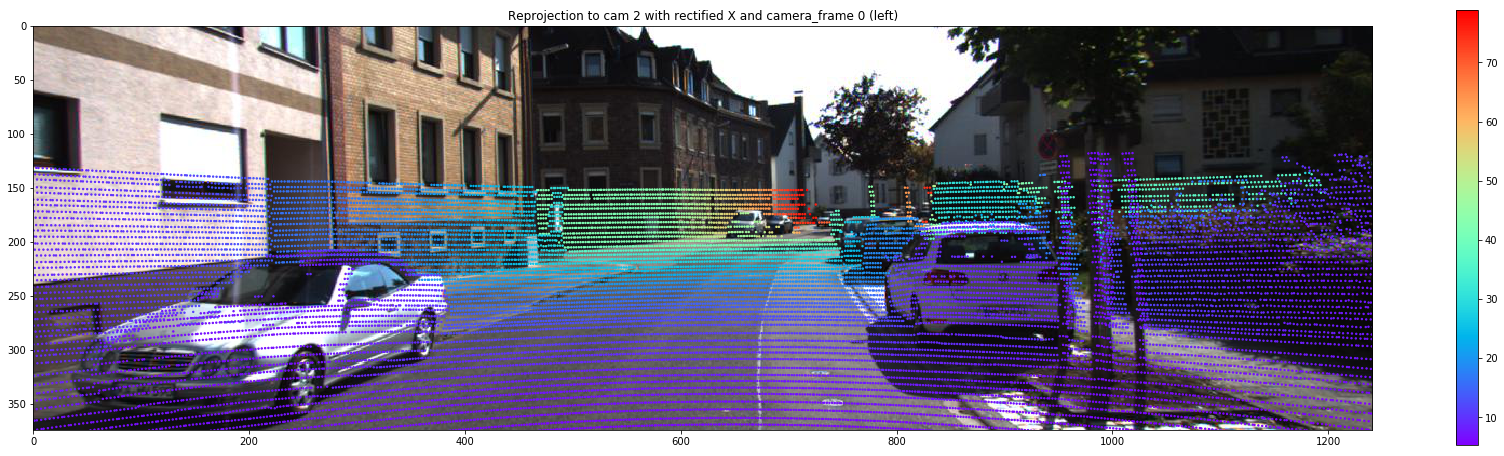

Reading from input list of param_list=[K, im_shape].


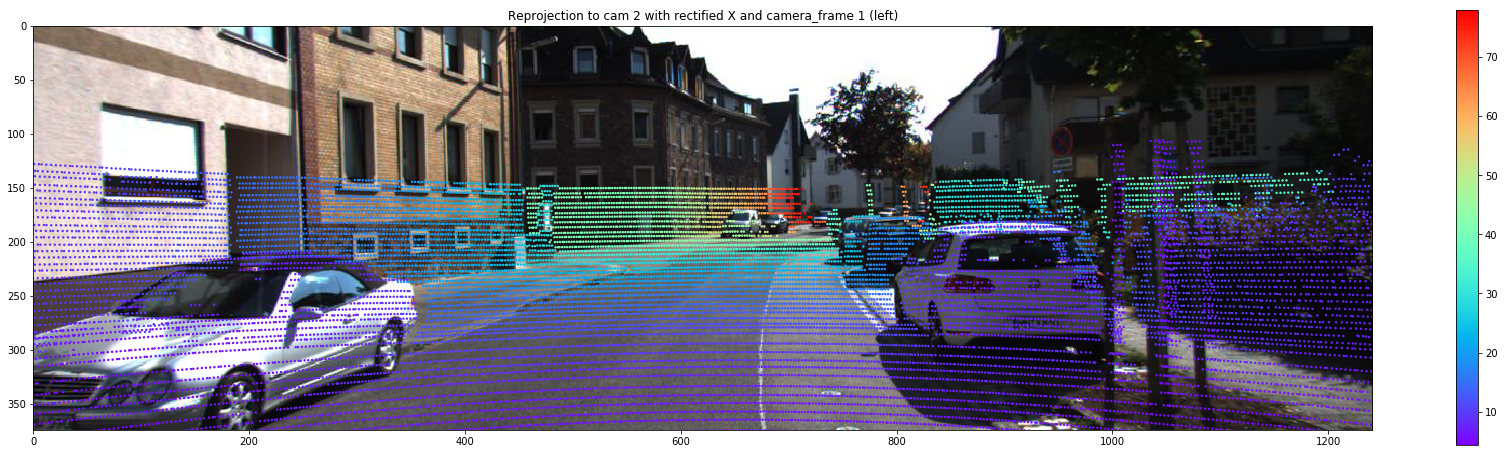

(2000, 4)


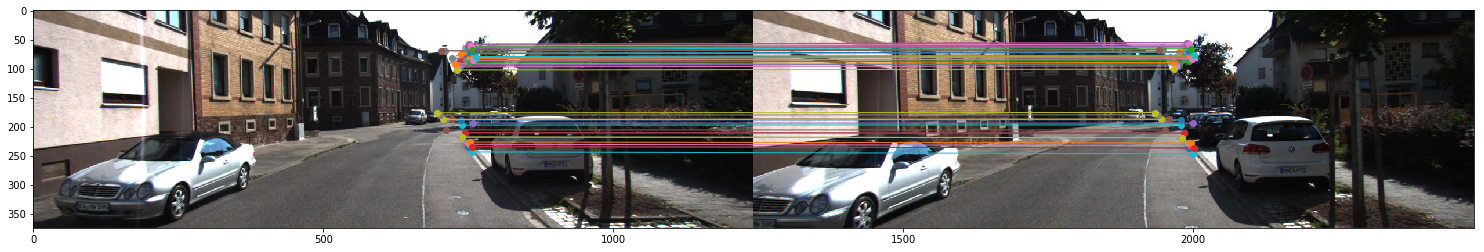

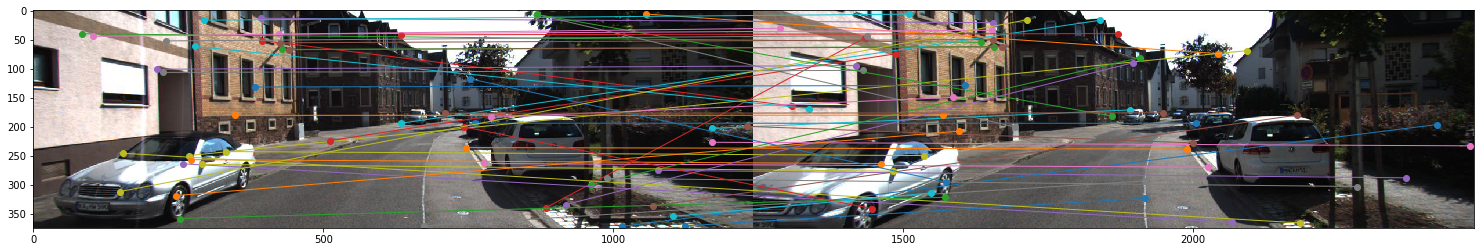

In [21]:
imgs, intrinsics, scene_name, frame_ids, Xs, sift_kps, sift_deses, scene_poses, matches_all, matches_good, get_flags = train_set.__getitem__(7)
print(scene_name, frame_ids, len(imgs))
import sys
sys.path.append("/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils")
sys.path.append("/home/ruizhu/Documents/Projects/kitti_instance_RGBD_utils/dsac_tools")
import utils_vis, utils_misc
if get_flags['sifts']:
    delta_Rtij = utils_misc.Rt_depad(scene_poses[-1]) # scene motion
    val_inds_i = utils_vis.reproj_and_scatter(utils_misc.identity_Rt(), Xs[0], imgs[0].astype(np.uint8), visualize=True, title_appendix='frame %d (left)'%0, param_list = [intrinsics, imgs[0].shape[:2]])
    val_inds_j = utils_vis.reproj_and_scatter(delta_Rtij, Xs[0], imgs[-1].astype(np.uint8), visualize=True, title_appendix='frame %d (left)'%1, param_list = [intrinsics, imgs[0].shape[:2]])

if get_flags['matches']:
    print(matches_all.shape)
    utils_vis.draw_corr(imgs[0].astype(np.uint8), imgs[-1].astype(np.uint8), matches_good[:50, :2], matches_good[:50, 2:], linewidth=1)
    utils_vis.draw_corr(imgs[0].astype(np.uint8), imgs[-1].astype(np.uint8), matches_all[:50, :2], matches_all[:50, 2:], linewidth=1)

{'Xs': True, 'sifts': True, 'matches': False}


In [98]:
np.set_printoptions(precision=4, suppress=True)
print(scene_poses[-1])

[[ 1.     -0.001  -0.002  -0.5182]
 [ 0.001   1.     -0.0079  0.0089]
 [ 0.002   0.0079  1.     -1.8198]
 [ 0.      0.      0.      1.    ]]


In [45]:
length = 10
sequence_length = 10
start_i = 0
delta_ij = 1
# print([idx*delta_ij+start_i for idx in range(sequence_length)])
max_idx = (sequence_length-1)*delta_ij
print(max_idx)

if  length <= max_idx:
    print('---', length, (sequence_length-1)*delta_ij)
    
for start_i in range(length - max_idx):
    print([idx*delta_ij+start_i for idx in range(sequence_length)])
    print(start_i)
    for delta_j in range(1, sequence_length):
            print(start_i+delta_j*delta_ij)


9
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
0
1
2
3
4
5
6
7
8
9


In [8]:
print(scene_poses[1])

-1


[2.91960788 2.47282767] [1237.02233887  363.6321106 ]


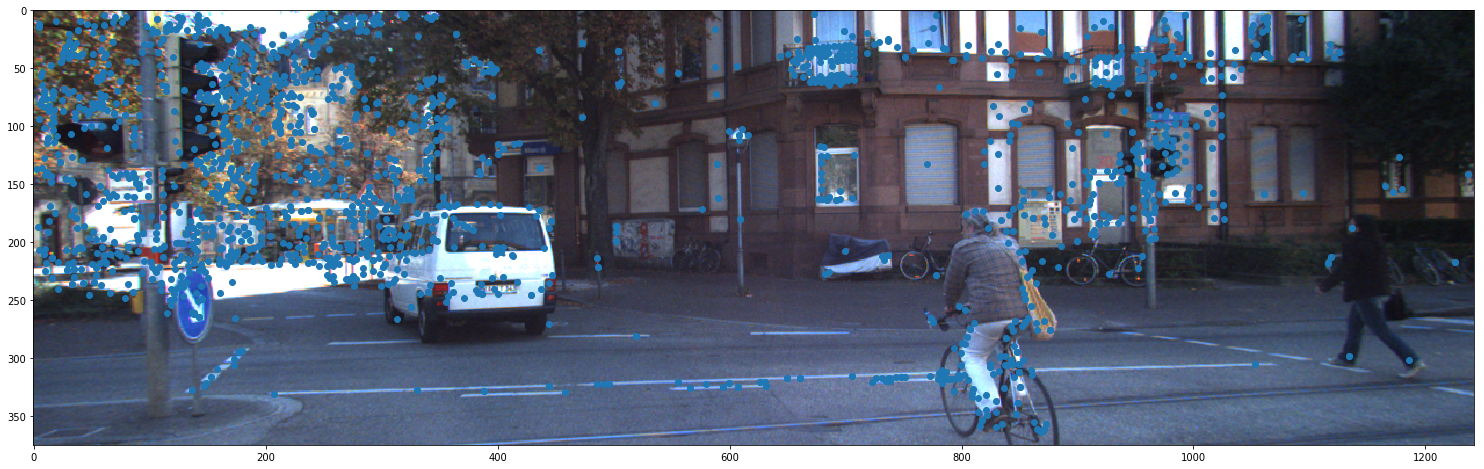

[-1.09992824 -1.09610513] [ 0.61045048 -0.59556401]


In [105]:
x = scene_list[0]['X_rect'][0]
xy = scene_list[0]['sift_kp'][0]
print(np.min(xy, 0), np.max(xy, 0))
im = scene_list[0]['img_l'][0]
K =  scene_list[0]['K']

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 8))
plt.imshow(im)
plt.scatter(xy[:, 0], xy[:, 1])
plt.show()

cx = (im.size[1] - 1.0) * 0.5
cy = (im.size[0] - 1.0) * 0.5
# Correct coordinates using K
cx += K[0, 2]
cy += K[1, 2]
# xy = np.array([_kp.pt for _kp in cv_kp])
# Correct focals
fx = K[0, 0]
fy = K[1, 1]
kp = (
    xy - np.array([[cx, cy]])
) / np.asarray([[fx, fy]])

print(np.min(kp, 0), np.max(kp, 0))

In [114]:
from dsac_tools.utils_misc import *
xy2 = de_homo_np((np.linalg.inv(K) @ homo_np(xy).T).T)
print(np.min(xy2, 0), np.max(xy2, 0))

[-0.84075952 -0.2361362 ] [0.8696192  0.26440491]


In [115]:
K

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [100]:
print(kp.shape)

(2000, 2)


In [92]:
im.size[1]

375

In [87]:
 scene_list[0]['K']

array([[721.5377,   0.    , 609.5593],
       [  0.    , 721.5377, 172.854 ],
       [  0.    ,   0.    ,   1.    ]])

In [ ]:
import matplotlib.pyplot as plt
